## ISYE 6402, Module 3 - PDC Energy, Inc (PDCE) Example

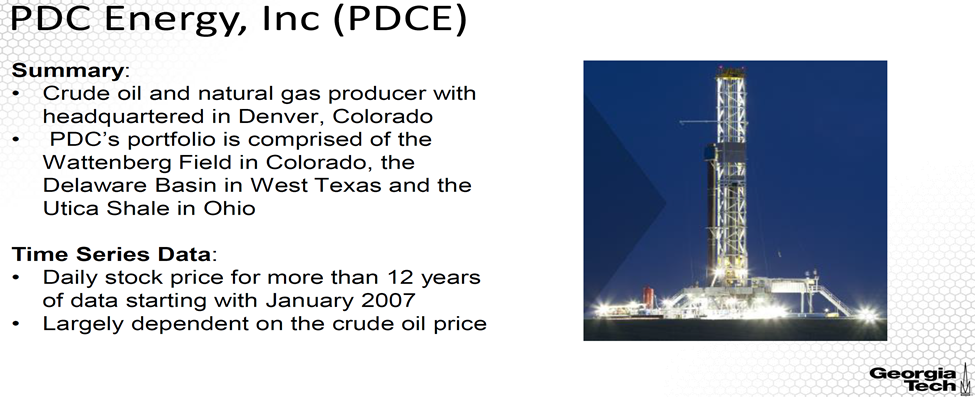

We'll consider one data example of a financial instrument, the stock price of a company. I selected here a company with very large volatility, PDC Energy, which is a crude oil and natural gas producer with headquarters in Denver, Colorado. Daily stock price for more than 12 years of data starting with January 2007 are considered in this data example. The reason for being interested in assessing volatility for this company is because it is highly dependent on the crude oil price, with extreme large volatility in recent years

### Financial Data Analysis

For this analysis, 
- I'm using R functions in the quantmod package, which is designed to assist the quantitative traders in the development testing and deployment of statistically-based trading models. 
- Using the R command getSymbols, it’s possible to load data from a variety of sources, including Yahoo Finance and Federal Reserve Bank. 
- In this implementation, the source is Yahoo. 
- The R command for plotting the time series is candleChart. We have seen other approaches to plot time series data. This command is yet another one! Here we are plotting the time series and its log return.

In [5]:
## Financial Data Analysis
library(quantmod)
library(xts)

In [6]:
options(repr.plot.width=12, repr.plot.height=6)

## Get the daily traiding data for PDCE
getSymbols("PDCE",src="yahoo")

head(PDCE)
tail(PDCE)

mydates = row.names(as.data.frame(PDCE))
mydates=as.Date(mydates,"%Y-%m-%d")
candleChart(PDCE,multi.col=TRUE,theme="white")

ERROR: Error in new.session(): Could not establish session after 5 attempts.


The time series plot of the close price along with the volume is on the slide. The time series is clearly **non-stationary with a nonlinear trend**. The price widely varied across years. It also seems that there are periods of very high volatility. 

### Difference Time Series Plot

In [3]:
# This code is different from given code. Removing last row from 'PDCE' which has two rows of data for the day 2022-03-25

l <- dim(PDCE)[1]
l

#dim(PDCE)[1]
df<-PDCE[1:(l-1),]
head(df)
tail(df)

mydates = row.names(as.data.frame(df))
mydates=as.Date(mydates,"%Y-%m-%d")
candleChart(df,multi.col=TRUE,theme="white")

ERROR: Error in eval(expr, envir, enclos): object 'PDCE' not found


              PDCE.Close
2007-01-03            NA
2007-01-04 -0.0350082813
2007-01-05 -0.0123533604
2007-01-08  0.0111490005
2007-01-09 -0.0007233997
2007-01-10 -0.0058054832

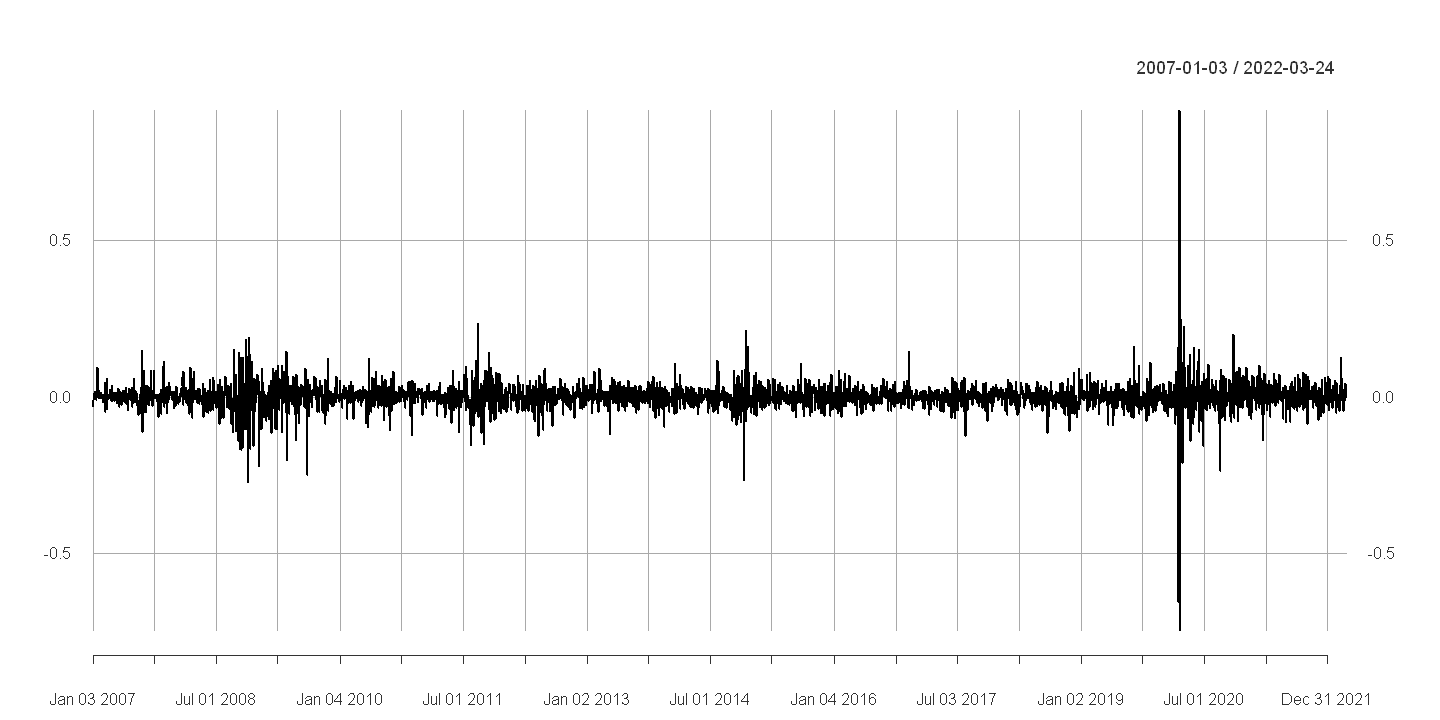

In [4]:
## Log returns of the close price ----- Givne the code
#pdcert <- diff(log(Cl(PDCE)))

pdcert <- diff(log(Cl(df)))
plot(pdcert,main="")

head(pdcert)

A better way to visualize volatility is by plotting the return of the log price. Here’s the time series of the return log price for PDCE. This time series clearly shows large volatility in the first quarter of 2019, for example, and as expected, during the covid19 crisis. This time series indicates that we have non-constant conditional variance or time-varying volatility

### ARIMA Fit & Model Selection

We'll first fit an ARMA model. For this, 

- we'll select the order of ARIMA, including the order of ARMA and the order of the integrated part of the model, specifically, p & q for ARMA and d for the difference.
- The code provided here is different from the one we used in fitting ARIMA models in the previous module. 
- The reason for using the code provided here is that in some ARIMA models for log return prices, it is possible that not all combinations of p,d,q to result in convergence hence the code may terminate without running through all combinations.
- For this, I am providing here an R function, called ‘test_modelA’ which fits an ARIMA model for the log return data given the ARIMA orders. 
- It then outputs the orders and the AIC value. Then I applied this R function for all order combinations while making sure that the for-loop does not terminate if non-convergence. 
- This last part is not shown on the slide. The output of this code is a data.frame called orders including information about AIC values and the corresponding orders.
- I also re-arranged this matrix such that the rows are ordered by AIC values.

In [5]:
## Fit ARIMA
n <- length(pdcert)

test_modelA <- function(p,d,q){
    mod = arima(pdcert, order=c(p,d,q), method="ML")
    current.aic <- AIC(mod)
    current.aic<-current.aic-2*(p+q+1)+2*(p+q+1)*n/(n-p-q-2)
    df = data.frame(p,d,q,current.aic)
    names(df) <- c("p","d","q","AIC")
    #print(paste(p,d,q,current.aic,sep=" "))
    return(df)
}

orders <- data.frame(Inf,Inf,Inf,Inf)
names(orders) <- c("p","d","q","AIC")
for (p in 0:6){
    for(d in 0:1) {
        for (q in 0:6) {
            possibleError <- tryCatch(
                orders<-rbind(orders,test_modelA(p,d,q)),
                error=function(e) e
            )
            if(inherits(possibleError, "error")) next
        }
    }
}

Warning message in log(s2):
"NaNs produced"
Warning message in arima(pdcert, order = c(p, d, q), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in arima(pdcert, order = c(p, d, q), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in arima(pdcert, order = c(p, d, q), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in arima(pdcert, order = c(p, d, q), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in arima(pdcert, order = c(p, d, q), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in log(s2):
"NaNs produced"
Warning message in arima(pdcert, order = c(p, d, q), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in arima(pdcert, order = c(p, d, q), method = "ML"):
"possible convergence problem: optim gave code = 1"
Warning message in ar

In [6]:
orders <- orders[order(-orders$AIC),]
tail(orders)

#tail(orders[order(-orders$AIC),])
#head(orders[order(orders$AIC),])

,p,d,q,AIC
,<dbl>,<dbl>,<dbl>,<dbl>
90,6,0,4,-13118.60
64,4,0,6,-13118.61
63,4,0,5,-13120.30
76,5,0,4,-13120.35
92,6,0,6,-13120.92
62,4,0,4,-13121.27


with tail(orders) showing the last few rows, where the last row of the matrix corresponds to the orders with the minimum AIC. 

The last row provides the orders with the lowest AIC value hence the selected orders using this approach are p=4, d=0 and q=4. 

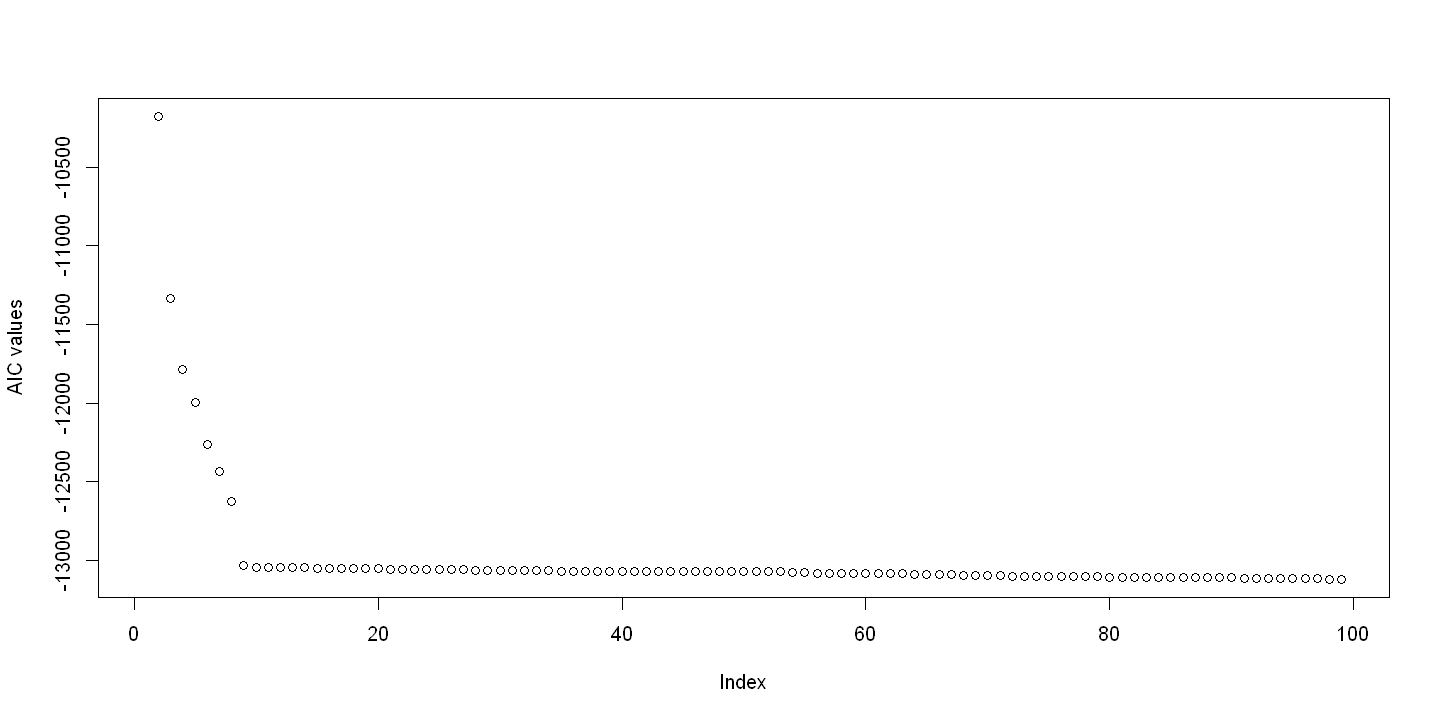

In [7]:
plot(orders$AIC,ylab="AIC values")

However, if we were to look at the AIC plot as provided, the AIC values drop significantly for the orders p=0, d=1 and q=1 then stay relatively small. (**Not in transcript - Need to add code to select orders p=0, d=1 and q=1)**

This suggests a more parsimonious model with these orders than the selected model with a similar performance in terms of AIC. Generally, we prefer more parsimonious or less complex models in forecasting.

### ARIMA Fit: Residual Analysis

Next, we perform the residual analysis for the two models. Specifically, we plot the ACF of the residual time series and of the squared residuals time series as provided on the slide. We do so for both models, the selected model with p=4, d=0 and q=4 and the parsimonious model with p=0, d=1 and q=1

In [8]:
select.arima <- arima(pdcert, order=c(4,0,4))
pars.arima <- arima(pdcert, order=c(0,1,1))

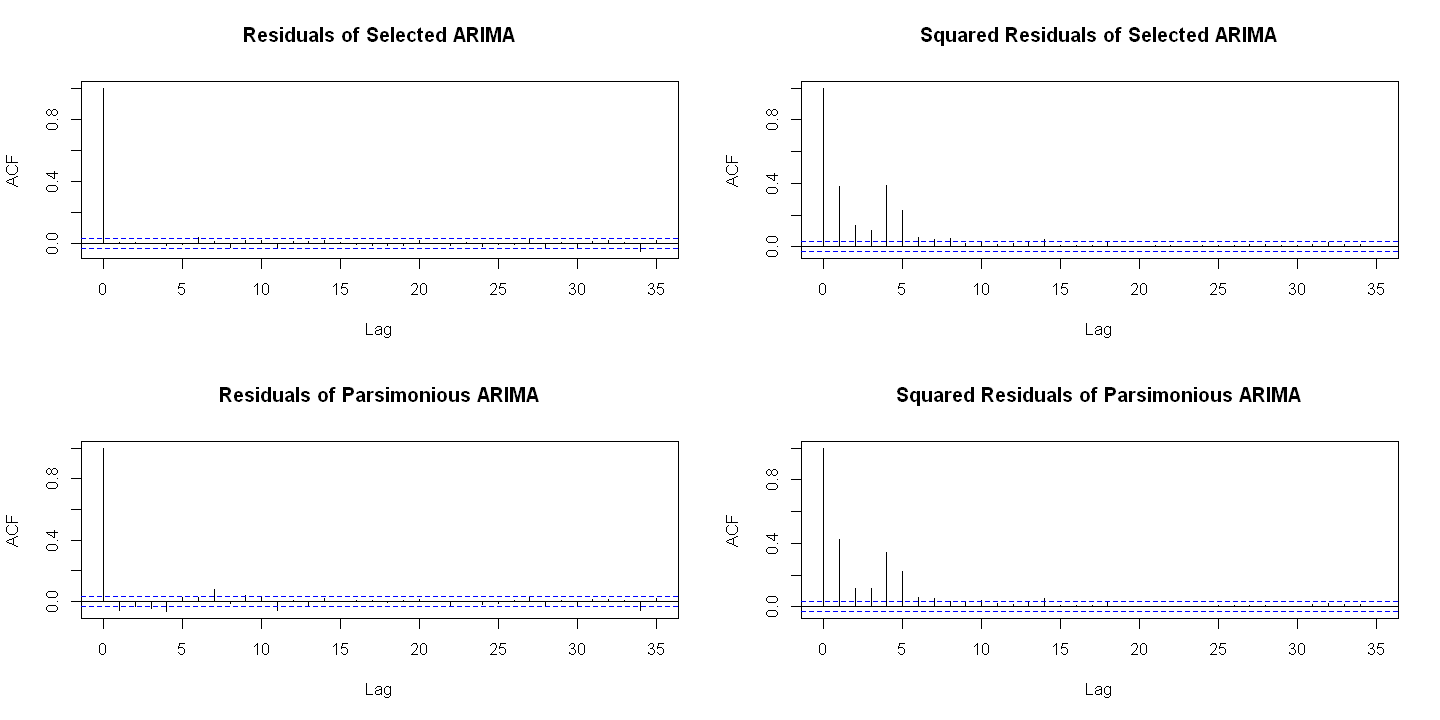

In [9]:
## Residual Analysis
select.resids <- resid(select.arima)[-1] #why [-1]?
pars.resids <- resid(pars.arima)[-1]

par(mfrow=c(2,2))
acf(select.resids,main="Residuals of Selected ARIMA")
acf(select.resids^2,main="Squared Residuals of Selected ARIMA")
acf(pars.resids,main="Residuals of Parsimonious ARIMA")
acf(pars.resids^2,main="Squared Residuals of Parsimonious ARIMA")

The ACF plots are here. The ACF plot of the residuals for both models looks like one for the white noise process. On the other hand, the ACF plot of the squared residuals suggests that there is a serial dependence in the squared residuals. 

There are few ACF values for lags 1 to 5 of the ACF plot of the squared residuals outside of the confidence band. Thus, the residuals are linearly uncorrelated, but not independent since the transformed residuals, specifically the squared residuals, are correlated.

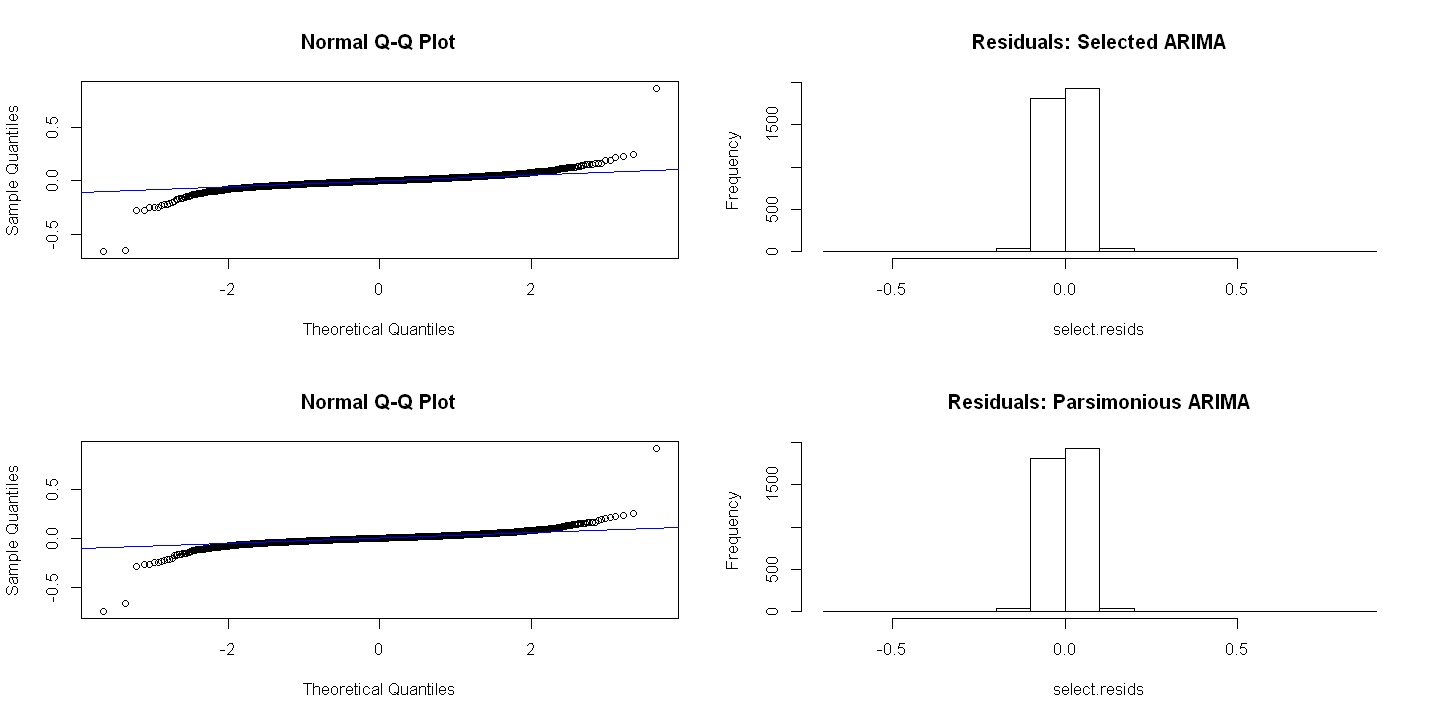

In [10]:
par(mfrow=c(2,2))

qqnorm(select.resids)
qqline(select.resids, col="blue")
hist(select.resids,main="Residuals: Selected ARIMA")
qqnorm(pars.resids)
qqline(pars.resids, col="blue")
hist(select.resids,main="Residuals: Parsimonious ARIMA")

In [11]:
# test for serial correlation in residuals
Box.test(select.resids,lag=9,type='Ljung',fitdf=8)
Box.test(pars.resids,lag=3,type='Ljung',fitdf=2)

# test for serial correlation in squared residuals
Box.test((select.resids)^2,lag=9,type='Ljung',fitdf=8)
Box.test((pars.resids)^2,lag=3,type='Ljung',fitdf=2)


	Box-Ljung test

data:  select.resids
X-squared = 10.97, df = 1, p-value = 0.0009258



	Box-Ljung test

data:  pars.resids
X-squared = 23.52, df = 1, p-value = 1.236e-06



	Box-Ljung test

data:  (select.resids)^2
X-squared = 1460.7, df = 1, p-value < 2.2e-16



	Box-Ljung test

data:  (pars.resids)^2
X-squared = 797.32, df = 1, p-value < 2.2e-16


Let's test whether the residuals and square residuals are correlated using hypothesis testing. We apply here the Box-Ljung test. Note that the test is not for testing independence, but for testing whether the data are uncorrelated where the null hypothesis is that the data aren't correlated versus the alternative that the data are correlated. 

The p-values for testing uncorrelated residuals are very small for both models, an indication that the residuals are correlated. However, the ACF plots from the previous slide look similarly to those of white noise.

The p-values for testing uncorrelated squared residuals are also very small indicating that we reject the null hypothesis, and thus, conclude that the squared residuals are correlated. Other tests can be applied as shown in one of the lessons of Module 1.

### Nonparametric Fit of Variance

Last, we estimate the variance using nonparametric regression. 
- For this, we take the log of squared residuals, and apply the nonparametric regression approach. 
- We can apply the splines regression model using the gam function in the mgcv library of R. 
- In this implementation, the response is the log of squared residuals.
- I am applying this approach only to the residuals from the selected ARMA model. 
- We further compare the fitted estimated trend from this nonparametric regression to the squared residuals. 
- For this, we have to extract the vector of dates as provided on the slide so that we will define the time series for the squared residuals and for the variance estimate.

Loading required package: nlme

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.



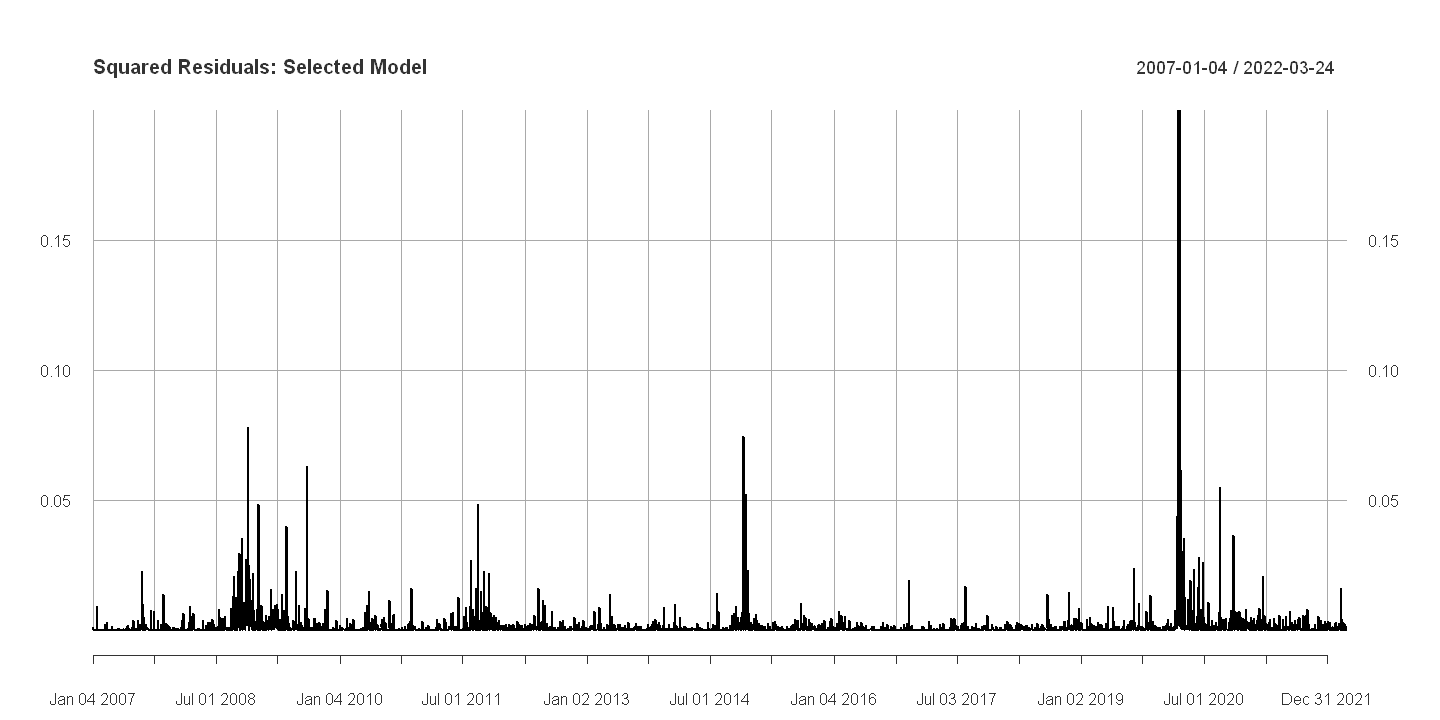

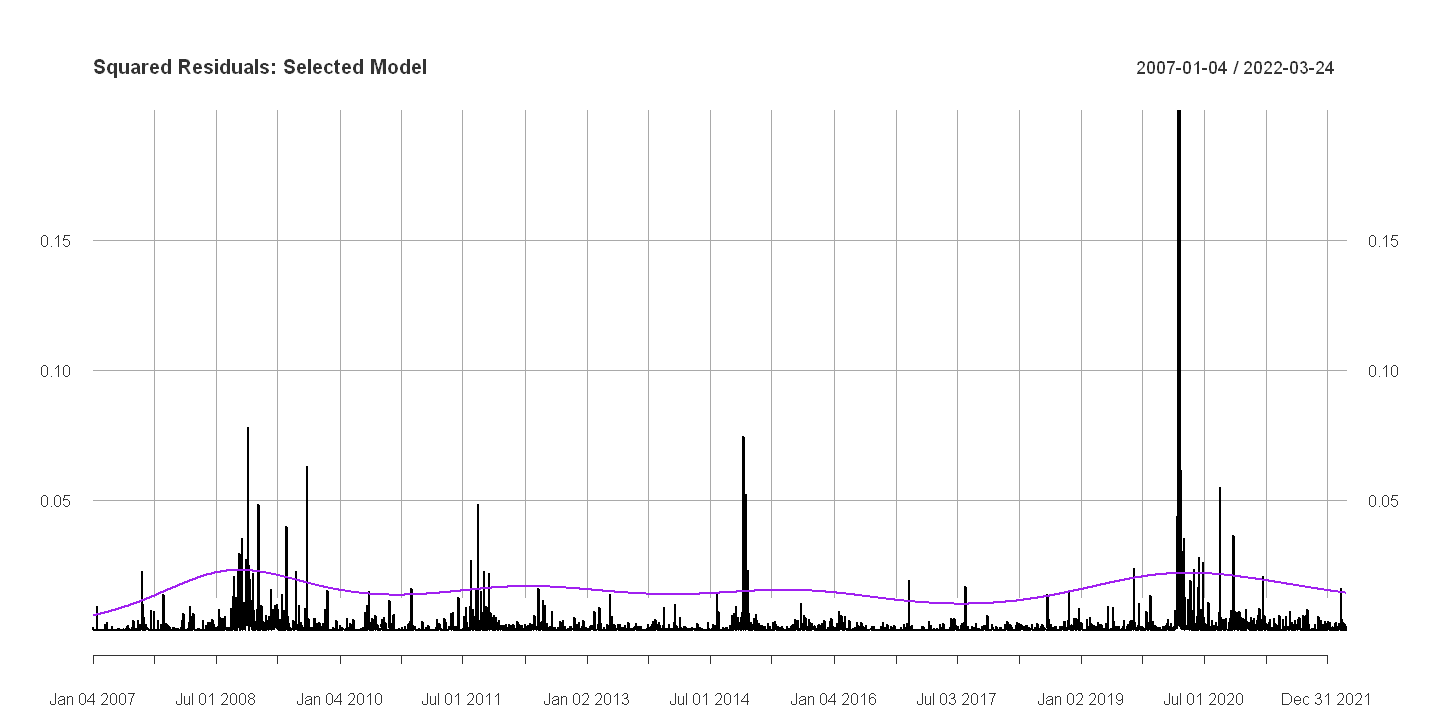

In [12]:
## Estimate the variance using nonparametric regression
library(mgcv)

zt.ssq.log = log(select.resids^2)
n = length(select.resids)

time.pts = c(1:n)
time.pts = (time.pts-min(time.pts))/(max(time.pts)-min(time.pts))
gam.var.select = gam(zt.ssq.log~s(time.pts))

pdcert.var.select=sqrt(exp(fitted(gam.var.select)))
tsresid.select=xts(select.resids,mydates[-1])
tspdcert.var.select = xts(pdcert.var.select,mydates[-1])
plot(tsresid.select^2,main='Squared Residuals: Selected Model',ylim=c(0,0.2))
lines(tspdcert.var.select,lwd=2,col="purple")

The plot of the fitted volatility is here. The estimated variance is shown in purple. We can see that the volatility has a nonlinear trend with several periods of years of high volatility. I will note here that I truncated the y-axis scale since the covid19 crisis again has shown volatility that is multiple folds higher, than experienced in previous years. The covid19 crisis was compounded with a large drop in oil prices that have led to such large volatility. 

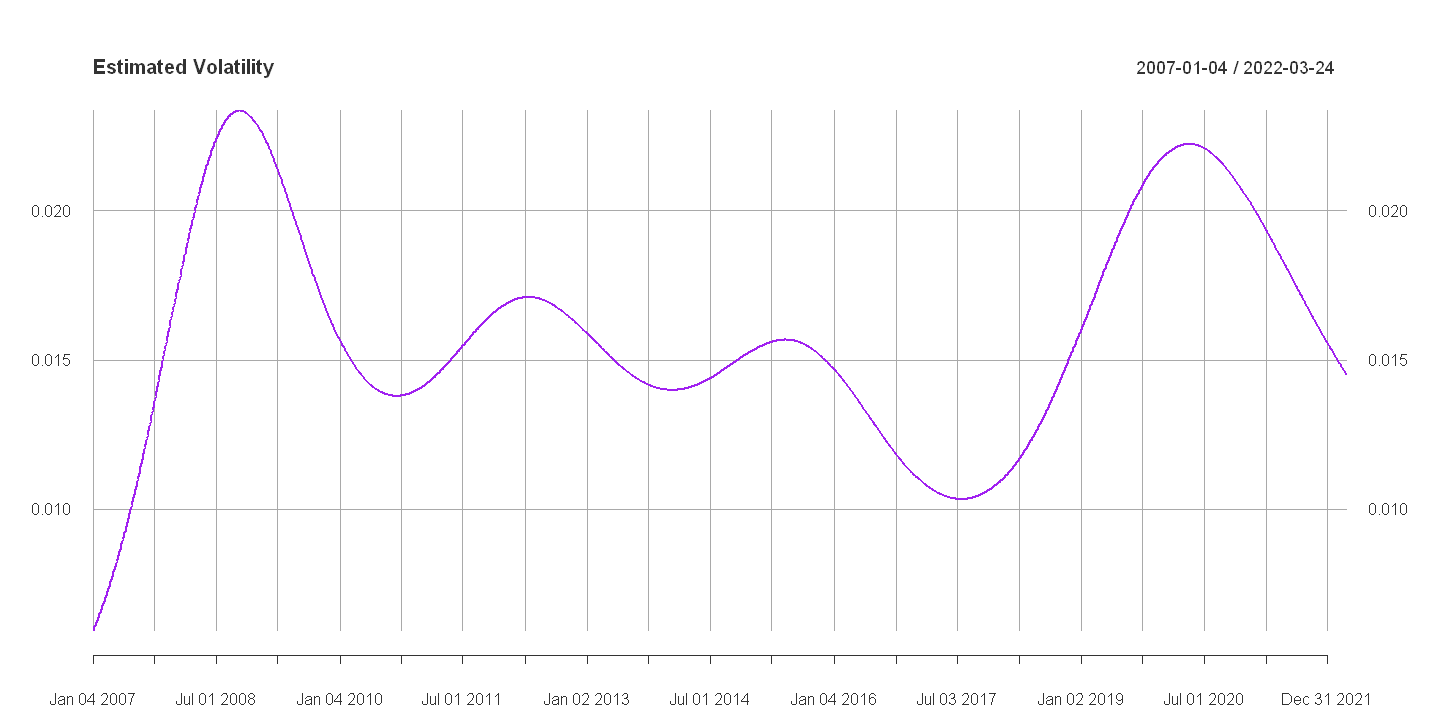

In [13]:
plot(tspdcert.var.select,lwd=2,col="purple",main='Estimated Volatility')

To see the clear volatility pattern, I also plotted the estimated variance alone without the squared residuals.

### ARCH Fit

In the lecture for ARMA modeling, we learned that we can identify the order of an AR process using the PACF plot. Since ARCH is an AR process for the squared Zt process or the squared residual process, we can use the PACF plot to identify the order of the ARCH model. Thus, in this example I used the R command PACF of the squared residual process. The PACF plot is on the right. From this plot we see that the PACF is large for the first seven orders but decreases afterwards. Using this approach, we may select an order equal to seven as fitted in the command on this slide using the garch() R command. In this command, we input the process to be modeled, in this case the residual process, and the order for the ARCH model.

Please pay attention on how the ARCH order is specified in this R command. We'll see other implementations of ARCH and GARCH models where the order is specified differently.

Last, we evaluate the goodness of fit by first obtaining the residuals from the ARCH model. Note that I remove the first seven values from the residual vector since there will be NA's. This is because we fit an ARCH model of order seven. I plotted here the ACF of the residuals and of the squared residuals from the ARCH model to check whether the residuals are uncorrelated and whether there is an ARCH effect left in the residuals.

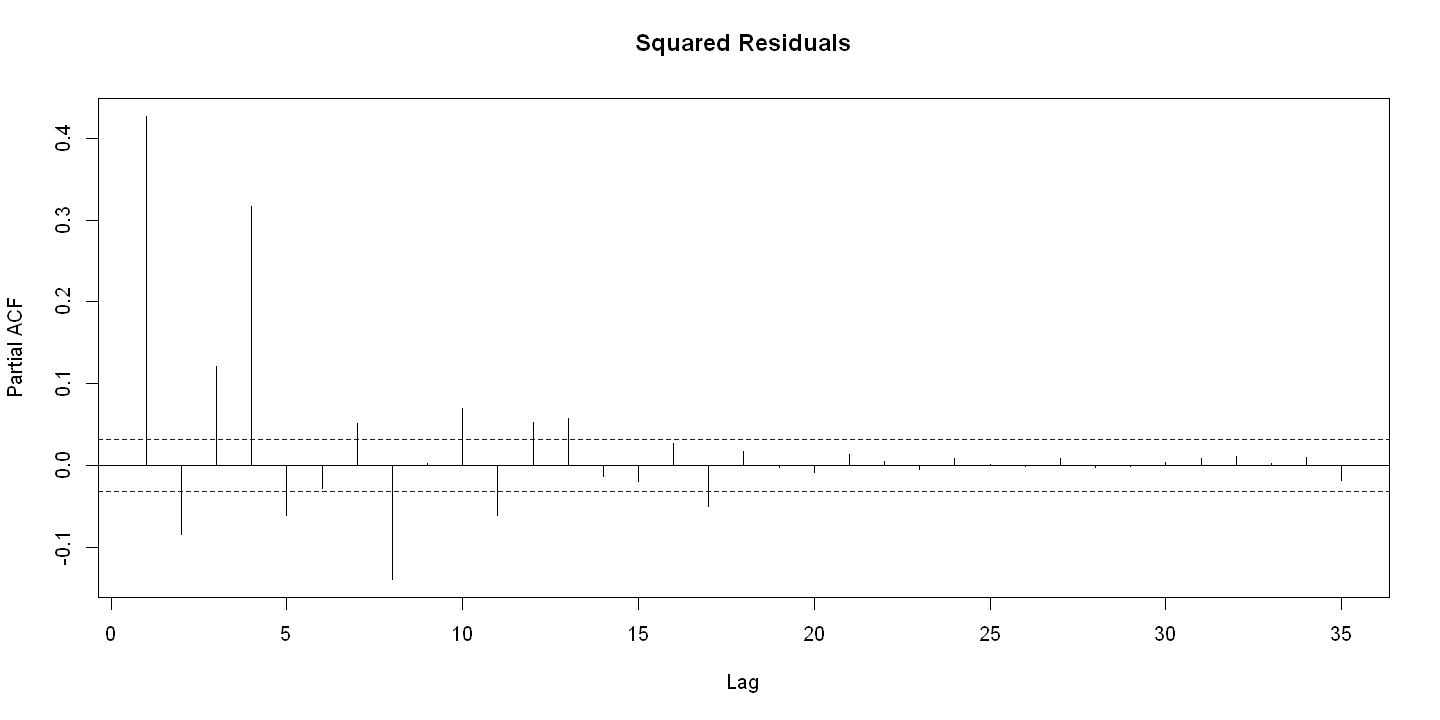

In [14]:
######## Apply ARCH Model ###################################################
## garch from tseries library
library(tseries)
resids <- pars.resids
pacf(resids^2,main="Squared Residuals")
arch.fit = garch(resids, order = c(0, 8),trace=F)

### ARCH Fit: Summary

In [15]:
summary(arch.fit)


Call:
garch(x = resids, order = c(0, 8), trace = F)

Model:
GARCH(0,8)

Residuals:
      Min        1Q    Median        3Q       Max 
-6.176275 -0.550988  0.008276  0.564970  4.913962 

Coefficient(s):
    Estimate  Std. Error  t value Pr(>|t|)    
a0 3.642e-04   2.186e-05   16.661  < 2e-16 ***
a1 1.950e-01   1.180e-02   16.527  < 2e-16 ***
a2 1.406e-01   1.411e-02    9.962  < 2e-16 ***
a3 6.383e-02   1.417e-02    4.503 6.69e-06 ***
a4 1.212e-01   1.397e-02    8.671  < 2e-16 ***
a5 4.774e-02   1.176e-02    4.060 4.90e-05 ***
a6 1.305e-01   1.013e-02   12.884  < 2e-16 ***
a7 4.928e-02   1.224e-02    4.027 5.65e-05 ***
a8 7.370e-02   1.330e-02    5.543 2.98e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Diagnostic Tests:
	Jarque Bera Test

data:  Residuals
X-squared = 1196.4, df = 2, p-value < 2.2e-16


	Box-Ljung test

data:  Squared.Residuals
X-squared = 0.077629, df = 1, p-value = 0.7805


The output of the ARCH fit is here. It is similar to that of an AR fit. The output provides the estimated error coefficients, along with the inference on statistical significance of the AR coefficients. 
According to this output, all coefficients are statistically significant hence, an order of seven or higher is appropriate. The output also provides the results from hypothesis testing procedures testing for uncorrelated residuals, and for an ARCH effect in the residuals. 

According to these two tests, we reject the null hypothesis of uncorrelated residuals, but do not reject the null hypothesis of an ARCH effect in the residuals.

### ARCH Fit: Residual Analysis

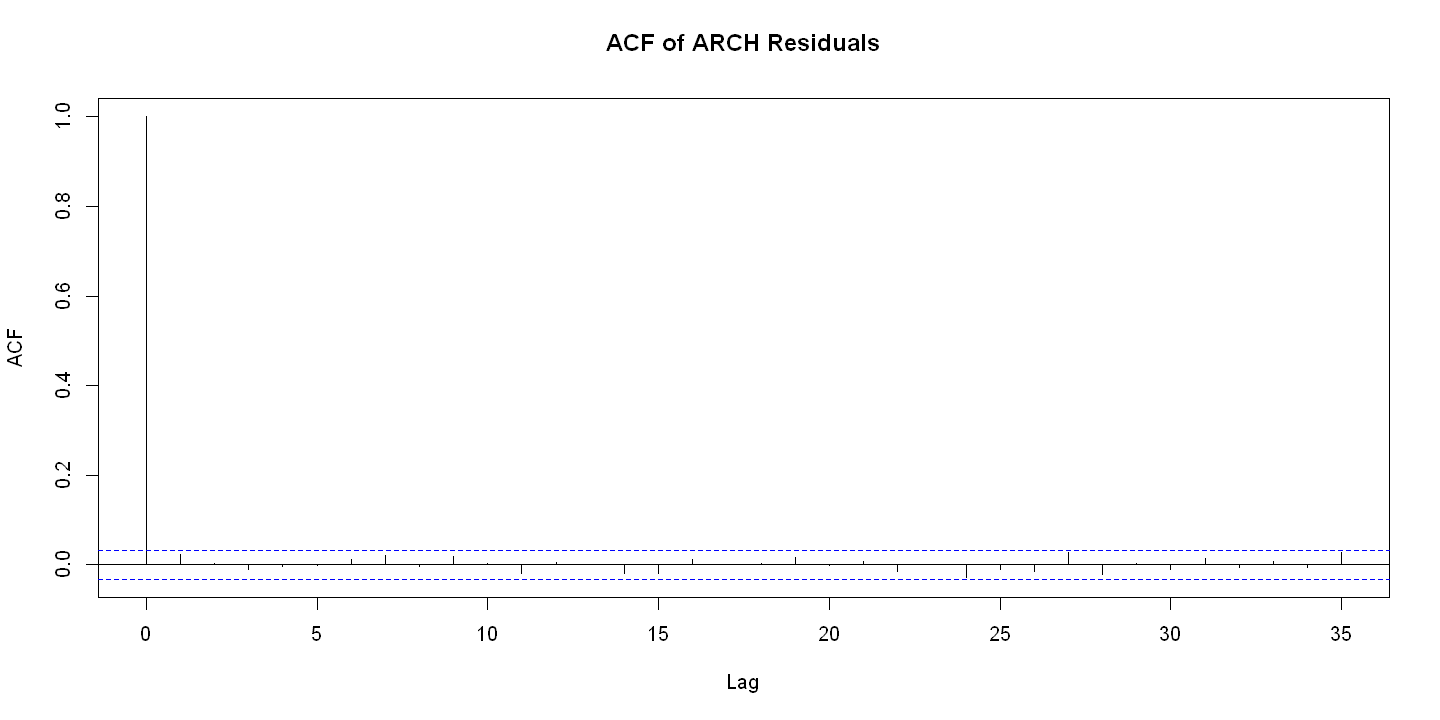

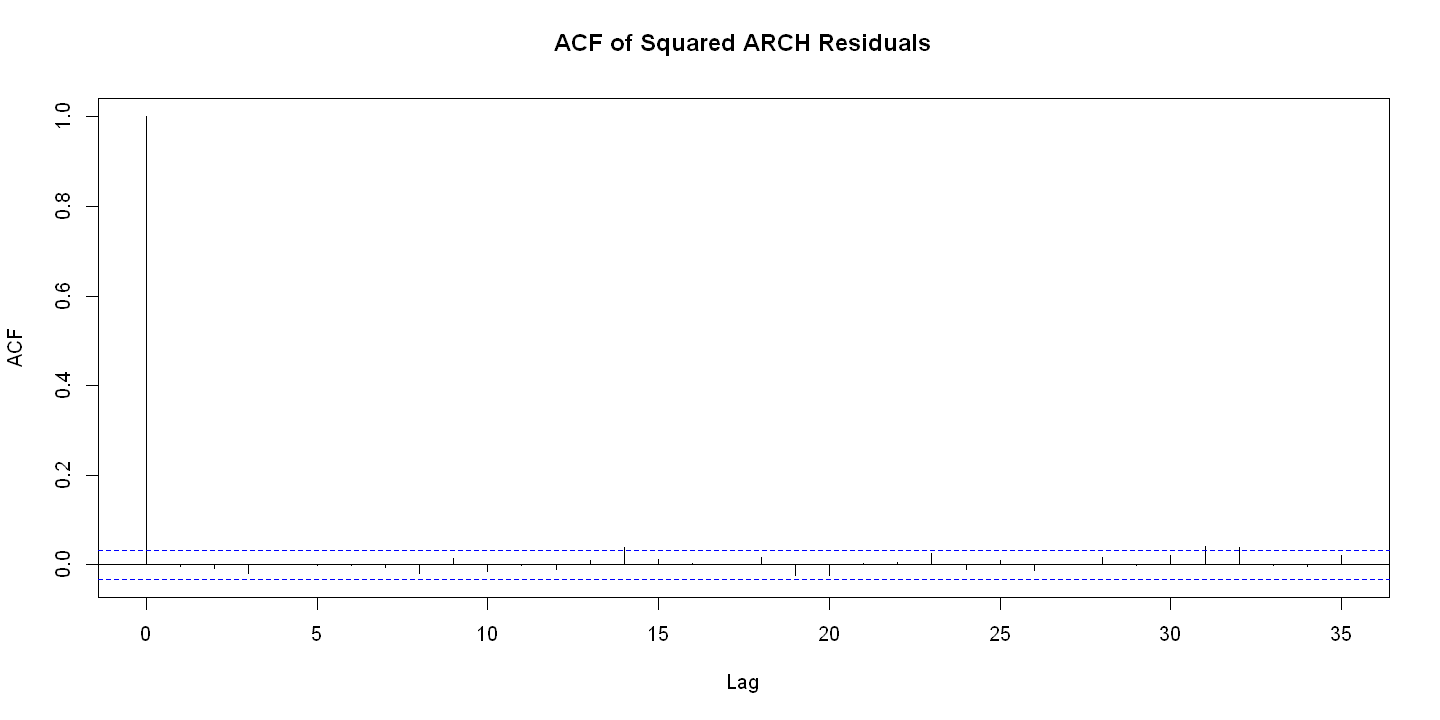

In [16]:
resids.fgarch = residuals(arch.fit)[-c(1:8)]
acf(resids.fgarch,main="ACF of ARCH Residuals")
acf(resids.fgarch^2,main="ACF of Squared ARCH Residuals")

The ACF plots on the other hand look like those of white noise since the ACF values are within the confidence band except for the lag 0.


	Box-Ljung test

data:  resids.fgarch
X-squared = 4.9233, df = 1, p-value = 0.0265



	Box-Ljung test

data:  resids.fgarch^2
X-squared = 3.5885, df = 1, p-value = 0.05818


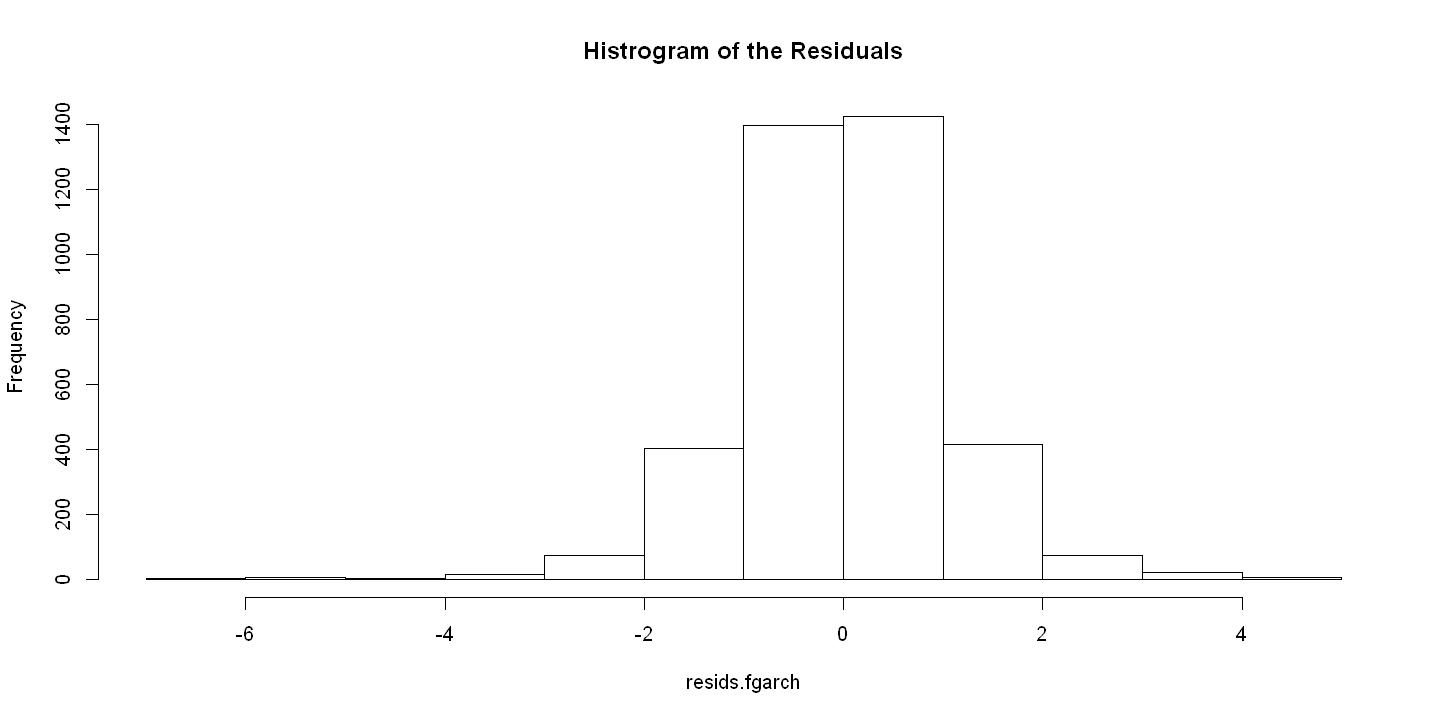

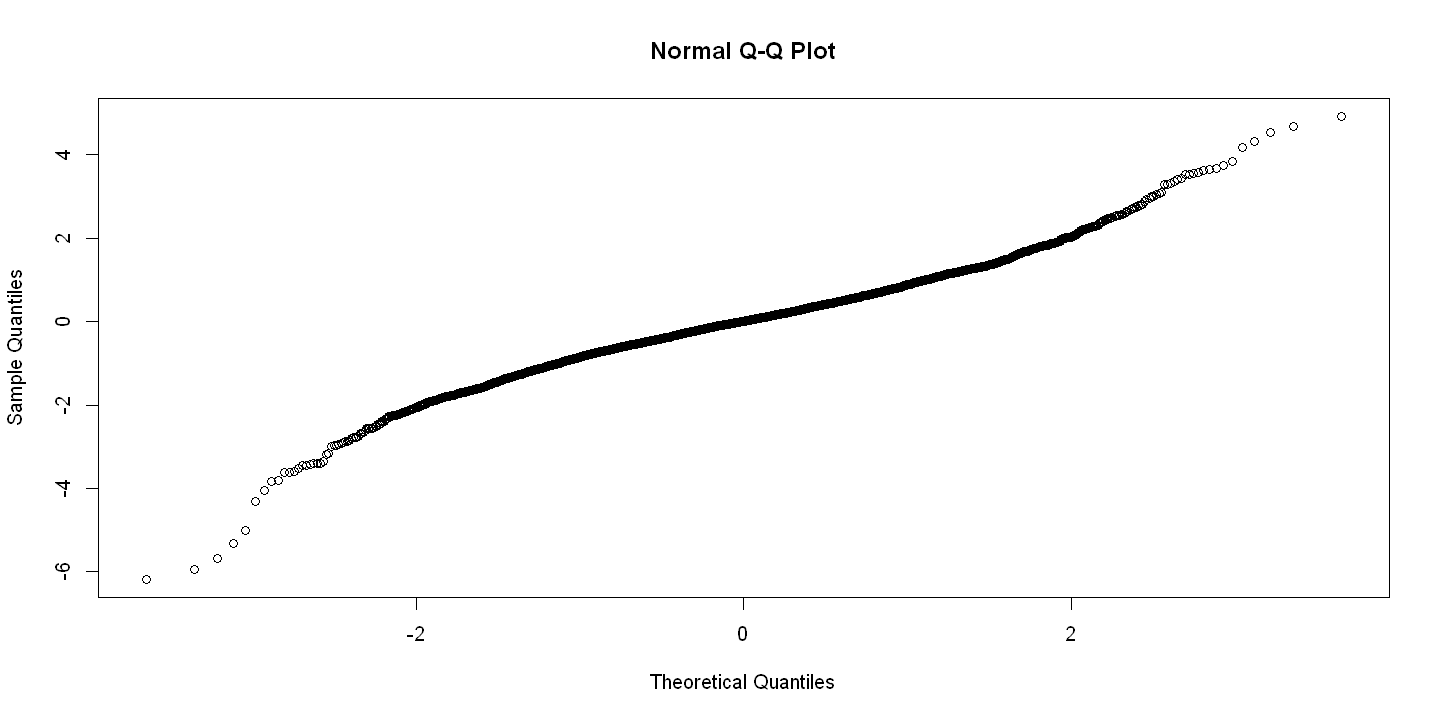

In [17]:
Box.test(resids.fgarch,lag=8,fitdf=7,type='Ljung')
Box.test(resids.fgarch^2,lag=8,fitdf=7,type='Ljung')
hist(resids.fgarch,main="Histrogram of the Residuals")
qqnorm(resids.fgarch)

### ARCH Fit: Different Implementations

I will note here that there are multiple R packages that can be used to fit ARCH models, and more generally GARCH models. One such implementation is using the Garch command from the ‘tseries’ package as demonstrated in the previous slides and a second implementation is the GarchFit() command from the fGarch package as demonstrated on this slide. The GARCH function from the tseries package is fast but does not always converge. The garchFit function from fGarch package is slower but does converge more consistently. 

In the implementation using the GarchFit command, we can fit the ARMA-ARCH model using the GarchFit function in two ways. 

- One is to fit an ARMA process on a time series first, then model the residuals from the ARMA fit using an ARCH model. This is the first implementation on this slide. However, this approach does not provide efficient estimates for the ARMA-ARCH joint model, not as efficient as the one when we estimated the two models simultaneously.

- We can also fit an ARCH model using the garchFit command by specifying the orders of the ARMA model through the option ARMA in this command. The orders of the ARCH model are further specified by the Garch option. Note that for this implementation the first order is for the AR part of the model and that is specified as Garch (8,0) in this implementation.

In [18]:
## garchFit from the fGarch library
#install.packages('fGarch')
library(fGarch)

Loading required package: timeDate

Loading required package: timeSeries


Attaching package: 'timeSeries'


The following object is masked from 'package:zoo':

    time<-


Loading required package: fBasics


Attaching package: 'fBasics'


The following object is masked from 'package:TTR':

    volatility




In [19]:
archFit.resid = garchFit(~ garch(8,0), data = resids, trace = FALSE)
summary(archFit.resid)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~garch(8, 0), data = resids, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(8, 0)
<environment: 0x0000000018a146b0>
 [data = resids]

Conditional Distribution:
 norm 

Coefficient(s):
        mu       omega      alpha1      alpha2      alpha3      alpha4  
0.00071262  0.00036556  0.19413638  0.13985374  0.06725519  0.11836101  
    alpha5      alpha6      alpha7      alpha8  
0.04558632  0.12886597  0.04886495  0.07397761  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     7.126e-04   4.818e-04    1.479 0.139110    
omega  3.656e-04   2.834e-05   12.899  < 2e-16 ***
alpha1 1.941e-01   2.541e-02    7.641 2.15e-14 ***
alpha2 1.399e-01   2.454e-02    5.698 1.21e-08 ***
alpha3 6.726e-02   2.093e-02    3.214 0.001310 ** 
alpha4 1.184e-01   2.025e-02    5.844 5.08e-09 ***
alpha5 4.559e-02   1.885e-02    2.418 0.015617 *  
alpha6 1.289e-01   2.005e-02    6.427 1.30e-10 **

### ARCH Fit: Comparison

*Actual model output is different from the slide (shown below). I added slide here for the equation/description purpose*

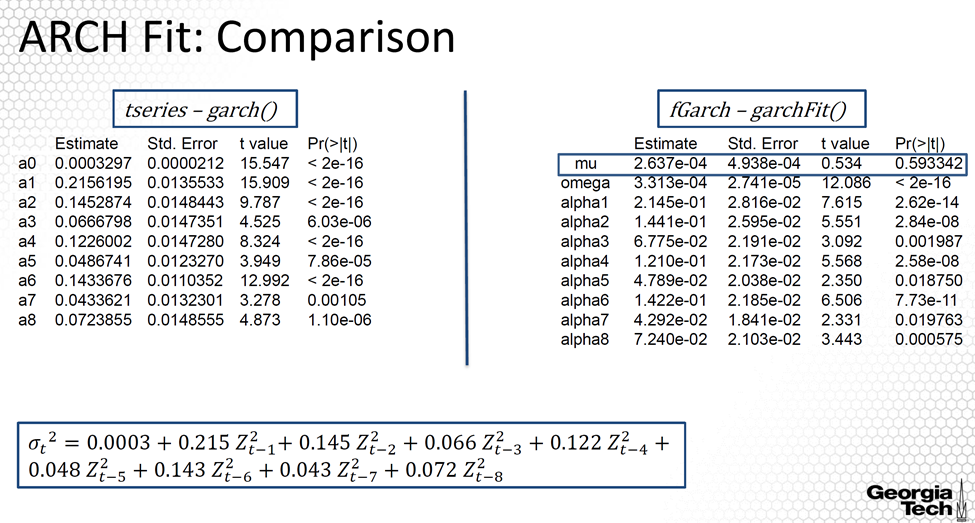


This slide compares the outputs using the two different implementations, specifically, using the garch() command on the left and the garchFit() command on the right applied to the residual process from the ARMA fit. 

- The omega coefficient using garchFit corresponds to the a0 coefficient using garch(). 
- The coefficients alpha1 to alpha8 correspond to the coefficients ar1 to ar8. 

**The estimates from the two models are almost identical.**


The difference between the output is that the garchFit function also provides the estimate for the mean of the fitted process, the mu parameter. In this case the estimate of the mean parameter mu is not statistically significant. This is not surprising since we applied the ARCH model on the residuals of an ARMA fit. 

Based on this output the fitted ARCH model is provided here on this slide, specifically the formula of the conditional variance as a function of Zt-1 up to Zt-8 since we fit an ARCH(8) model.


### ARMA-ARCH Fit: Summary

In [20]:
archFit.ts = garchFit(~ arma(4,4)+ garch(8,0), data=pdcert[-1], trace = FALSE)
summary(archFit.ts)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~arma(4, 4) + garch(8, 0), data = pdcert[-1], 
    trace = FALSE) 

Mean and Variance Equation:
 data ~ arma(4, 4) + garch(8, 0)
<environment: 0x00000000073569f0>
 [data = pdcert[-1]]

Conditional Distribution:
 norm 

Coefficient(s):
         mu          ar1          ar2          ar3          ar4          ma1  
 0.00061907   0.79518830   0.37844100  -0.93031683   0.09380352  -0.77360773  
        ma2          ma3          ma4        omega       alpha1       alpha2  
-0.39045889   0.90398684  -0.06772419   0.00036167   0.19226828   0.13765186  
     alpha3       alpha4       alpha5       alpha6       alpha7       alpha8  
 0.06737123   0.11994788   0.04073647   0.13111859   0.04946362   0.08069821  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      6.191e-04   3.300e-04    1.876 0.060655 .  
ar1     7.952e-01   1.483e-01    5.361 8.26e-08 ***
ar2     3.784e-01   1.469e-01   

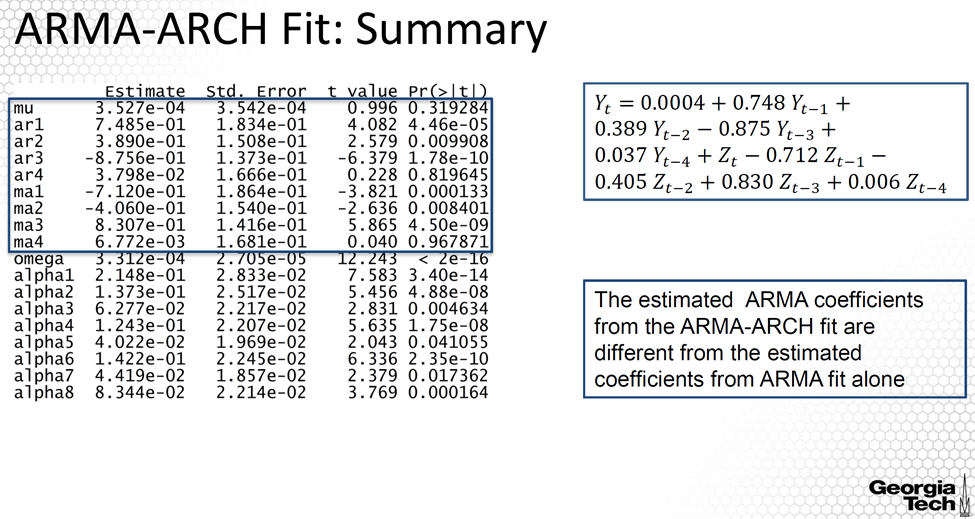

This is the output from the joint modeling of ARMA-ARCH applied to the time series of the return stock price using the garchFit command. 

The first part of the output is for the ARMA model, specifically the estimated ARMA coefficients. The output provided for the ARMA-ARCH model fit is different from the output of the ARCH fit using the residual process. 


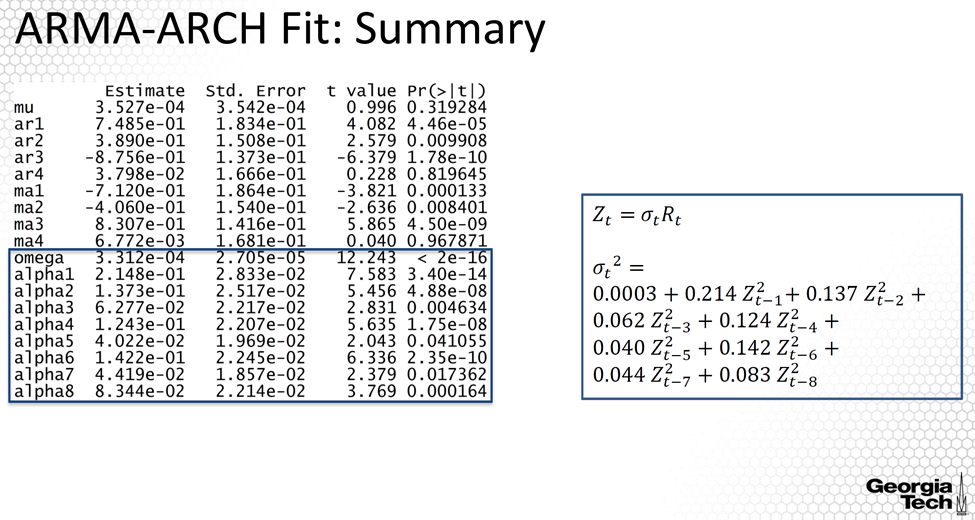


- If we compare the estimates from the ARMA process that we initially estimated disregarding the ARCH portion of the model to the estimated coefficients using the joint ARMA-ARCH model, we find that the estimated ARMA coefficients are different. 
- On the other hand, if we compare the ARCH fitted model using the ARMA-ARCH fit versus the ARCH model on the residuals, the fitted models are similar. 

### GARCH Model

### ARMA-GARCH Fit

We will begin with a simple implementation of an ARMA-GARCH joint model. I will apply a similar R command as we did for fitting the ARCH model, specifically the garchFit() command. This command allows fitting a joint ARMA-GARCH model as specified in the command on the slide. In this example, I used the same orders for the ARMA model that we fit previously on the log return for PDCE stock price, specifically, orders 4 and 4. Again this will model the conditional mean only. I also used a GARCH(1,1) to model the condition variance. 

While the model fit using this implementation works fine, this R command will often fail to provide predictions when we have an ARMA-GARCH joint model.

In [21]:
######## Apply GARCH Model #############################################
##divide into training and testing
## Predict August & Septmeber 1-16 
pdcert2 = pdcert[-1]
n=length(pdcert2)
pdcert.test = pdcert2[3419:n]
pdcert.train =  pdcert2[-c(3419:n)]

## garchFit from the fGarch library
library(fGarch)
garchFit.ts = garchFit(~ arma(4,4)+ garch(1,1), data=pdcert.train, trace = FALSE)
# Prediction of garchFit does not work properly when considering joint arma+garch
#fore_garch11 = predict(garchFit.ts, n.ahead = 32)

summary(garchFit.ts)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~arma(4, 4) + garch(1, 1), data = pdcert.train, 
    trace = FALSE) 

Mean and Variance Equation:
 data ~ arma(4, 4) + garch(1, 1)
<environment: 0x0000000006004138>
 [data = pdcert.train]

Conditional Distribution:
 norm 

Coefficient(s):
         mu          ar1          ar2          ar3          ar4          ma1  
 7.9629e-04   3.7312e-01   4.4521e-03   2.2462e-01  -8.2433e-01  -3.4225e-01  
        ma2          ma3          ma4        omega       alpha1        beta1  
-1.6935e-02  -2.5058e-01   8.3309e-01   4.8919e-05   1.5932e-01   8.1679e-01  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      7.963e-04   6.100e-04    1.305  0.19177    
ar1     3.731e-01   1.206e-01    3.094  0.00198 ** 
ar2     4.452e-03   7.345e-02    0.061  0.95167    
ar3     2.246e-01   9.563e-02    2.349  0.01883 *  
ar4    -8.243e-01   1.111e-01   -7.418 1.19e-13 ***
ma1    -3.423e-01   1.110e-01 

### ARMA-GARCH Fit: Different Implementation

Since prediction is an important aspect in modeling time series, I will introduce yet another implementation, which is a bit more challenging to implement and it is more computationally expensive, but overall has better performance since it generally converges for any combination of orders. 

In this implementation, I first define the model's specifications through the ugarchspec() R command. 
- The model's specifications are similar to those from the model fitted in the previous slide, particularly, the ARMA orders are 4 and 4, the GARCH orders are 1 and 1. 
- We consider the mean to be nonzero, through the option include.mean=T and we assume the t-distribution instead of normal distribution through the specification of the option distribution.model. 
- Then the model is fitted using the ugarchfit with the formulation specified by the specifications provided in the ugarchspec. 

All R commands used in this slide are available in rugarch library. This library is the most recent implementation of the ARMA-GARCH model. It provides many more modeling options for modeling the conditional mean and the conditional variance jointly, as I will show in the rest of the lessons of this module.

Last, the predictions for both the conditional mean and the conditional variance work for this implementation as I will illustrate later in this lesson.

### ARMA+GARCH Order Selection

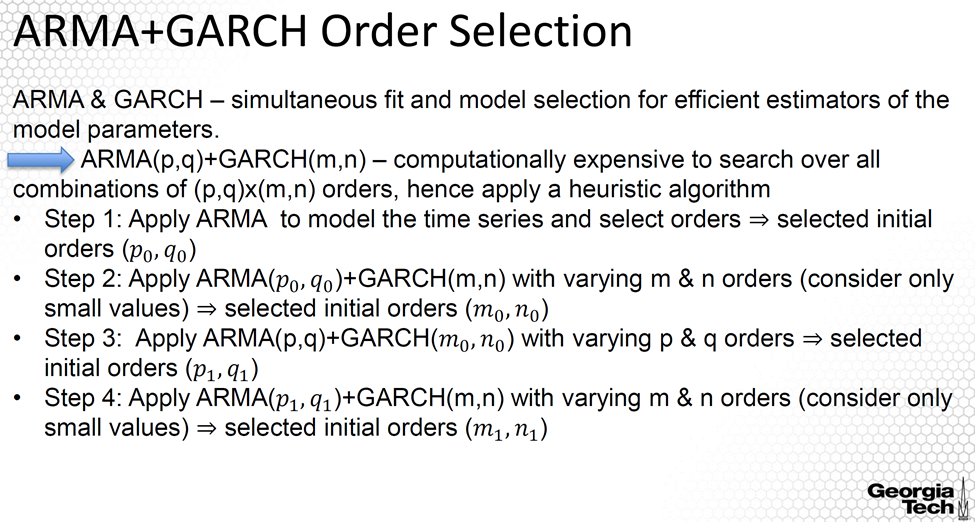

### Step 2: GARCH Order Selection

Here, we consider modeling the return price using a joint ARMA-GARCH model. At Step 2 of order selection, we fix the ARMA orders to be the selected orders (4,4) using the AIC approach from the previous lesson, then we'll select the orders of the GARCH model. 

This R function fits the ARMA-GARCH model with ARMA(4,4) and GARCH(m,n) with m and n as the input. The function outputs the BIC value for the input m and n orders. Note that here I am using  BIC instead of AIC to select the orders. This is because BIC prefers smaller, less complex models. Selecting lesser complex models here is important because we fit an ARMA-GARCH joint model which is already very complex.

Then I used this function to apply it for a range of m and n values taking values 0, 1, and 2 hence a maximum order of 2. To select the order, we loop over all combinations of orders m and n. Note that we consider somewhat smaller orders for GARCH than we used for ARMA modeling, since a small GARCH model is commonly sufficient in modeling the volatility or conditional variance. Note that it is still possible that the model fit not to converge for some combination of orders. We thus skip these models as provided in the code. 

In this example, the selected GARCH orders are m equal to 2 and n equal to 2. *(which is different from what below code outputs)*

In [22]:
##### Order Selection ################################################
## Find GARCH Order given ARMA order identified before
## ugrach from rugarch libary
library(rugarch)
#Initial GARCH Order
#ARIMA-GARCH: Select GARCH order
test_modelAGG <- function(m,n){
    spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                      mean.model=list(armaOrder=c(4,4),
                                      include.mean=T),
                      distribution.model="std")
    fit = ugarchfit(spec, pdcert.train, solver = 'hybrid')
    current.bic = infocriteria(fit)[2]
    df = data.frame(m,n,current.bic)
    names(df) <- c("m","n","BIC")
    print(paste(m,n,current.bic,sep=" "))
    return(df)
}

ordersAGG = data.frame(Inf,Inf,Inf)
names(ordersAGG) <- c("m","n","BIC")

for (m in 0:2){
    for (n in 0:2){
        possibleError <- tryCatch(
            ordersAGG<-rbind(ordersAGG,test_modelAGG(m,n)),
            error=function(e) e
        )
        if(inherits(possibleError, "error")) next
    }
}
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)
# 2,2

Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma




[1] "0 0 -3.9074370982015"
[1] "0 1 -3.90725648441111"
[1] "0 2 -3.90486608459831"
[1] "1 0 -3.90627498511455"
[1] "1 1 -4.03677866738515"
[1] "1 2 -4.0296229251416"
[1] "2 0 -3.97649100501695"
[1] "2 1 -4.03066724146889"
[1] "2 2 -4.03332104751298"


,m,n,BIC
,<dbl>,<dbl>,<dbl>
2,0,0,-3.907437
8,2,0,-3.976491
7,1,2,-4.029623
9,2,1,-4.030667
10,2,2,-4.033321
6,1,1,-4.036779


### Step 3: ARMA Order Selection Update

At the next step, we apply a similar code as for Step 1, except that now we fix the GARCH orders to the orders selected in Step 2, specifically the GARCH orders are m equal to 2 and n equal to 2. Then perform the fit given the p & q orders of ARMA.

In [23]:
#ARMA update
#ARIMA-GARCH: Select ARIMA order
test_modelAGA <- function(p,q){
    spec = ugarchspec(variance.model=list(garchOrder=c(2,2)),
                      mean.model=list(armaOrder=c(p,q),
                                      include.mean=T),
                      distribution.model="std")
    fit = ugarchfit(spec, pdcert.train, solver = 'hybrid')
    current.bic = infocriteria(fit)[2]
    df = data.frame(p,q,current.bic)
    names(df) <- c("p","q","BIC")
    print(paste(p,q,current.bic,sep=" "))
    return(df)
}

ordersAGA = data.frame(Inf,Inf,Inf)
names(ordersAGA) <- c("p","q","BIC")
for (p in 0:4){
    for (q in 0:4){
        possibleError <- tryCatch(
            ordersAGA<-rbind(ordersAGA,test_modelAGA(p,q)),
            error=function(e) e
        )
        if(inherits(possibleError, "error")) next
    }
}
ordersAGA <- ordersAGA[order(-ordersAGA$BIC),]
tail(ordersAGA)
# Don't choose 0,0 since it's trivial.
#0,1

[1] "0 0 -4.04330670884537"
[1] "0 1 -4.04119329517866"
[1] "0 2 -4.03885226832539"
[1] "0 3 -4.03670864005797"
[1] "0 4 -4.03414370132857"
[1] "1 0 -4.04118959053894"
[1] "1 1 -4.03882386115557"
[1] "1 2 -4.03658935131522"
[1] "1 3 -4.03432812588396"
[1] "1 4 -4.03176415110889"
[1] "2 0 -4.03885594490324"
[1] "2 1 -4.03660382269467"
[1] "2 2 -4.03712973544895"
[1] "2 3 -4.03320236799018"
[1] "2 4 -4.0320554130671"
[1] "3 0 -4.03673050769357"
[1] "3 1 -4.03435026676978"
[1] "3 2 -4.03465381341255"
[1] "3 3 -4.03474223011774"


Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"


[1] "3 4 -4.02891023853021"
[1] "4 0 -4.03416749116414"
[1] "4 1 -4.03191091332069"
[1] "4 2 -4.03209833918404"
[1] "4 3 -4.03019001681918"
[1] "4 4 -4.03332104751298"


,p,q,BIC
,<dbl>,<dbl>,<dbl>
8,1,1,-4.038824
4,0,2,-4.038852
12,2,0,-4.038856
7,1,0,-4.041190
3,0,1,-4.041193
2,0,0,-4.043307


Next we loop over all combinations of p & q orders for the ARMA model of the conditional mean and apply the R function provided in the previous slide. Similar to Step 2, it is possible that the model fit not to converge for some combination of orders. We thus skip these models as provided in the code.

**The selected orders for modeling the conditional mean based on this approach are AR order or p = 0 and MA order or q=0. Since this is the trivial model, we choose: AR=0, MA=1 instead.**

### Step 4: GARCH Order Selection Update

This step is similar to Step 2 except that now we use the updated ARMA model orders as provided in Step 3. 

The selected orders for modeling the conditional variance are GARCH(1,1).

In [24]:
#GARCH update
test_modelAGG <- function(m,n){
    spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                      mean.model=list(armaOrder=c(0,1),
                                      include.mean=T), distribution.model="std")
    fit = ugarchfit(spec, pdcert.train, solver = 'hybrid')
    current.bic = infocriteria(fit)[2]
    df = data.frame(m,n,current.bic)
    names(df) <- c("m","n","BIC")
    print(paste(m,n,current.bic,sep=" "))
    return(df)
}

ordersAGG = data.frame(Inf,Inf,Inf)
names(ordersAGG) <- c("m","n","BIC")

for (m in 0:2){
    for (n in 0:2){
        possibleError <- tryCatch(
            ordersAGG<-rbind(ordersAGG,test_modelAGG(m,n)),
            error=function(e) e
        )
        if(inherits(possibleError, "error")) next
    }
}
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)
# Final ARMA(0,1)+GARCH(1,1) selected 

[1] "0 0 -3.92066743244894"
[1] "0 1 -3.91969815294484"
[1] "0 2 -3.9162676203284"
[1] "1 0 -3.9648464622775"
[1] "1 1 -4.04600147275746"
[1] "1 2 -4.04357387441356"
[1] "2 0 -3.99029271399225"
[1] "2 1 -4.04353311554777"
[1] "2 2 -4.04119329517866"


,m,n,BIC
,<dbl>,<dbl>,<dbl>
5,1,0,-3.964846
8,2,0,-3.990293
10,2,2,-4.041193
9,2,1,-4.043533
7,1,2,-4.043574
6,1,1,-4.046001


### ARMA+GARCH Fit: Model Evaluation

Next we will evaluate three models, with the selected orders as given at the steps provided above. From the order selection analysis provided in the previous steps, we saw that as we refined or updated the orders, with  the selected models in the later steps being more parsimonious; for example, 

- the first model after Step 2 is an ARMA(4,4)-GARCH(2.2). 
- The second model after performing Step 3 is ARMA(0,1)-GARCH(2.2). 
- The third model after Step 4 is ARMA(0,1)-GARCH(1.1).  

**A parsimonious model is one that does not have a large number of parameters to estimate, that is one with small orders for the ARMA-GARCH models.**

Here we are applying the infocriteria() command in R to compare the three models based on multiple model evaluation criteria, including AIC and BIC.

In [25]:
### Goodness of Fit ####################################################
spec.1 = ugarchspec(variance.model=list(garchOrder=c(2,2)),
                 mean.model=list(armaOrder=c(4, 4),
                 include.mean=T), distribution.model="std")
final.model.1 = ugarchfit(spec.1, pdcert.train, solver = 'hybrid')

spec.2 = ugarchspec(variance.model=list(garchOrder=c(2,2)),
                 mean.model=list(armaOrder=c(0, 1),
                 include.mean=T), distribution.model="std")
final.model.2 = ugarchfit(spec.2, pdcert.train, solver = 'hybrid')

spec.3 = ugarchspec(variance.model=list(garchOrder=c(1,1)),
                 mean.model=list(armaOrder=c(0, 1),
                 include.mean=T), distribution.model="std")
final.model.3 = ugarchfit(spec.3, pdcert.train, solver = 'hybrid')

## compare Information Criteria
infocriteria(final.model.1)
infocriteria(final.model.2)
infocriteria(final.model.3)

,
Akaike,-4.060253
Bayes,-4.033321
Shibata,-4.060291
Hannan-Quinn,-4.050629


,
Akaike,-4.055557
Bayes,-4.041193
Shibata,-4.055568
Hannan-Quinn,-4.050424


,
Akaike,-4.056774
Bayes,-4.046001
Shibata,-4.056780
Hannan-Quinn,-4.052925


The output is here. The first two values are for the Akaike information criteria, or AIC, and for the Bayes information criteria, or BIC. In this example the values across the four criteria are very similar for the three models. Since we prefer less complex models, thus we would chose the last model, where we have an ARMA with orders 0, 1 and a GARCH with orders 1 and 1.

### Residual Analysis

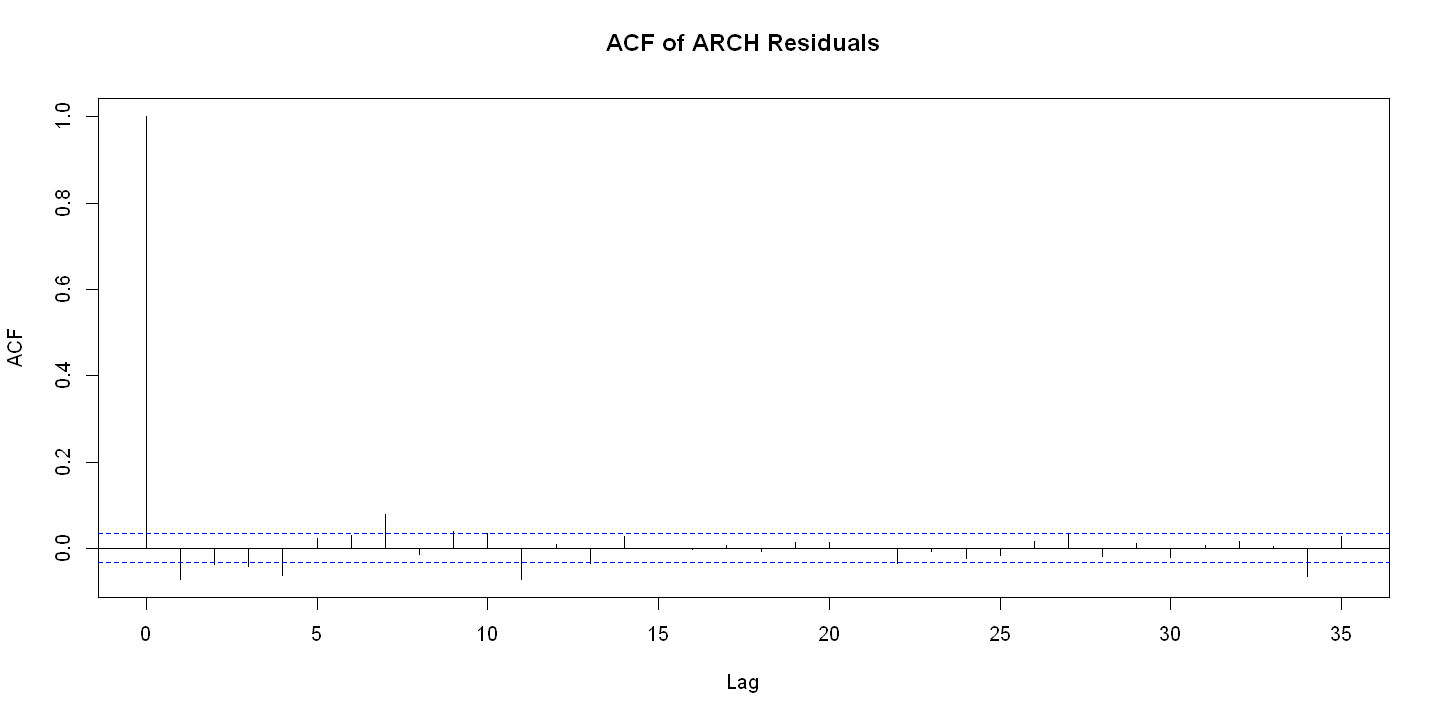


	Box-Ljung test

data:  resids.final.model
X-squared = 78.775, df = 10, p-value = 8.722e-13



	Box-Ljung test

data:  resids.final.model^2
X-squared = 1342.6, df = 10, p-value < 2.2e-16


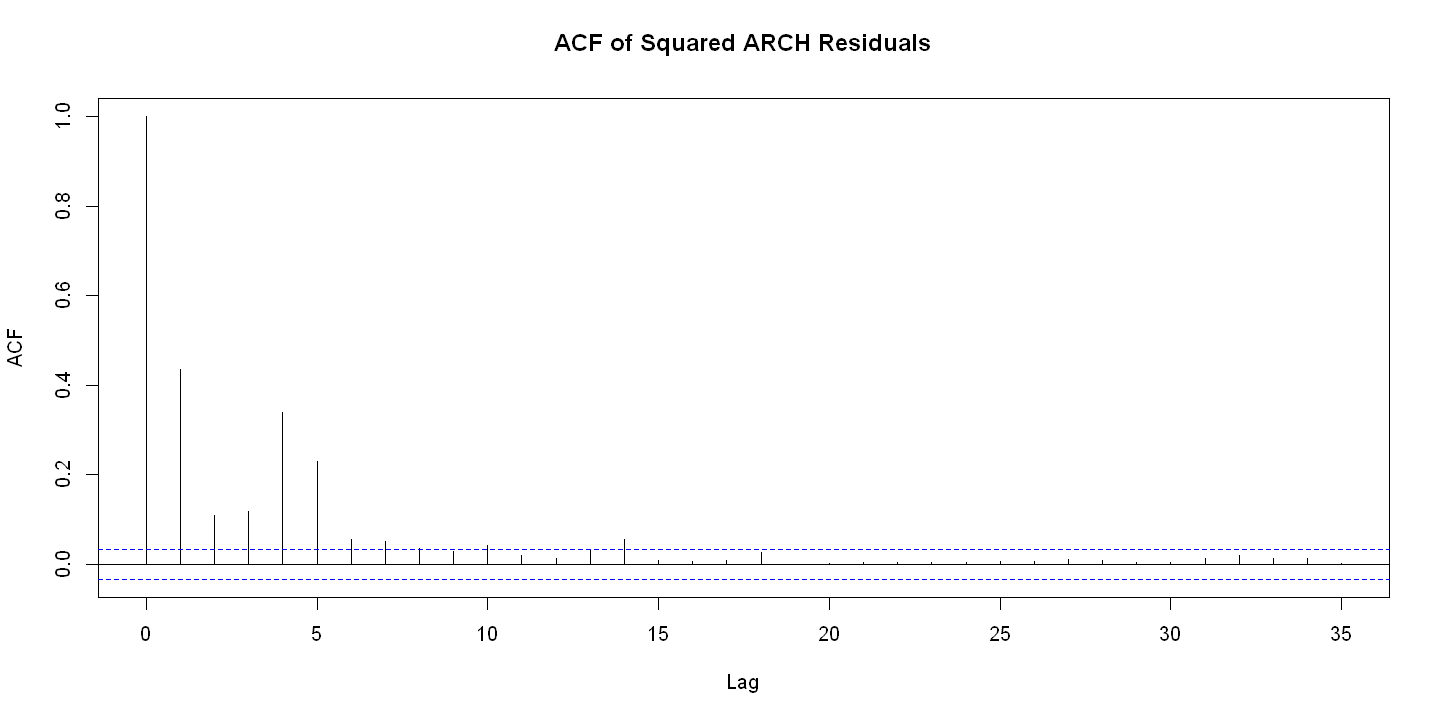

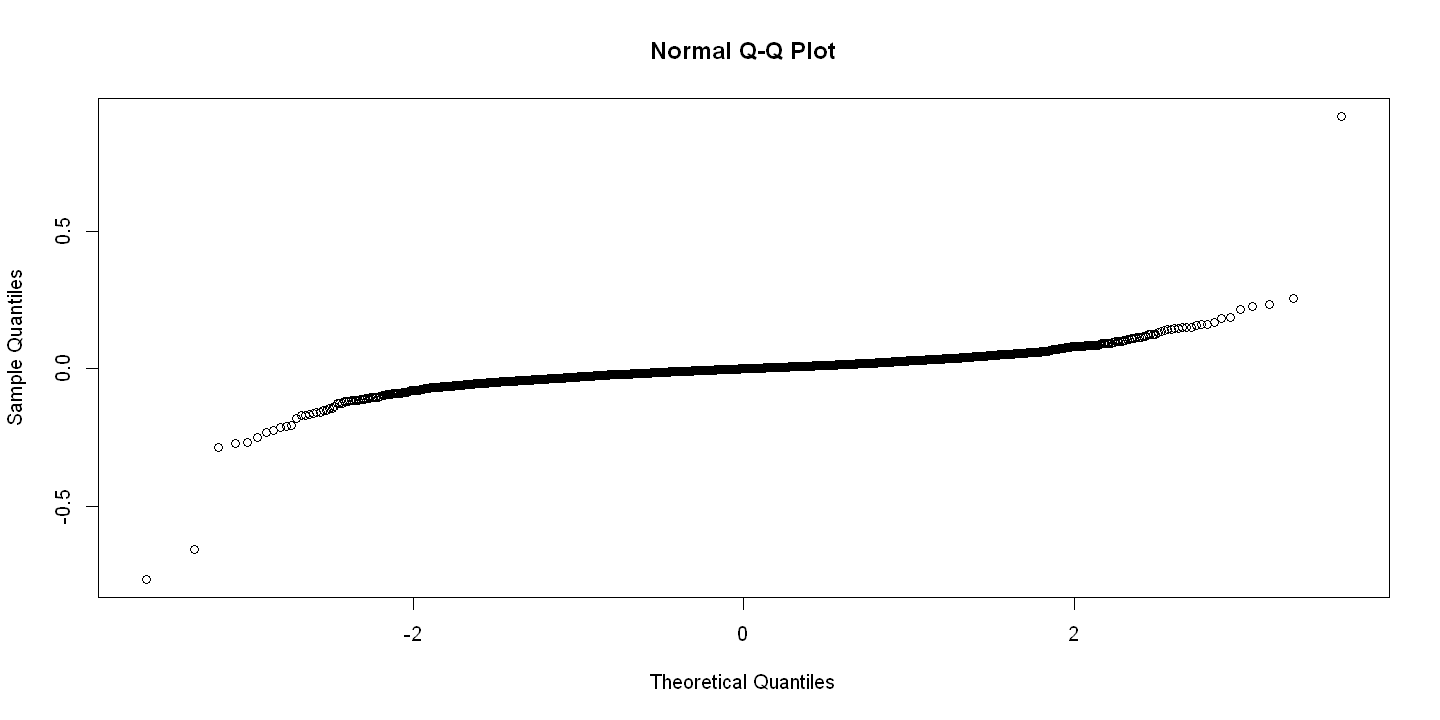

In [26]:
## Residual Analysis
resids.final.model = residuals(final.model.3)
acf(resids.final.model,main="ACF of ARCH Residuals")
acf(resids.final.model^2,main="ACF of Squared ARCH Residuals")
Box.test(resids.final.model,lag=10,type='Ljung')
Box.test(resids.final.model^2,lag=10,type='Ljung')
qqnorm(resids.final.model)

These are the ACF plots for the residuals and the squared residuals of the selected (third) model. Based on these plots, the ACF of the residuals resembles the ACF of white noise. However, this is not the case for the squared residuals suggesting that a higher order GARCH model may be considered.

### Forecasting: Mean & Volatility

The R code on this slide is for obtaining the predictions for the conditional mean and for the conditional variance or so-called volatility. The prediction is performed one lag ahead on a rolling basis. The code on the slide is for the first model, but I applied the code to obtain the predictions using the other two models also. The output consists of forecasts for the return price for the conditional mean and the conditional variance.

In [27]:
### 1-lag Ahead Rolling Prediction ##################################################

## 1. Prediction of the return time series
## 2. Prediction of the volatility
nfore = length(pdcert.test)
fore.series.1 = NULL
fore.sigma.1 = NULL
fore.series.2 = NULL
fore.sigma.2 = NULL
fore.series.3 = NULL
fore.sigma.3 = NULL
for(f in 1: nfore){
    ## Fit models
    data = pdcert.train
    if(f>2)
       data = c(pdcert.train,pdcert.test[1:(f-1)])
    final.model.1 = ugarchfit(spec.1, data, solver = 'hybrid')
    final.model.2 = ugarchfit(spec.2, data, solver = 'hybrid')
    final.model.3 = ugarchfit(spec.3, data, solver = 'hybrid')
    ## Forecast
    fore = ugarchforecast(final.model.1, n.ahead=1)
    fore.series.1 = c(fore.series.1, fore@forecast$seriesFor)
    fore.sigma.1 = c(fore.sigma.1, fore@forecast$sigmaFor)
    fore = ugarchforecast(final.model.2, n.ahead=1)
    fore.series.2 = c(fore.series.2, fore@forecast$seriesFor)
    fore.sigma.2 = c(fore.sigma.2, fore@forecast$sigmaFor)
    fore = ugarchforecast(final.model.3, n.ahead=1)
    fore.series.3 = c(fore.series.3, fore@forecast$seriesFor)
    fore.sigma.3 = c(fore.sigma.3, fore@forecast$sigmaFor)
}

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
"possible convergence problem: optim gave code = 1"


### Prediction Accuracy Comparison

In [28]:
## Compute Accuracy Measures

### Mean Squared Prediction Error (MSPE)
mean((fore.series.1 - pdcert.test)^2)
mean((fore.series.2 - pdcert.test)^2)
mean((fore.series.3 - pdcert.test)^2)
### Mean Absolute Prediction Error (MAE)
mean(abs(fore.series.1 - pdcert.test))
mean(abs(fore.series.2 - pdcert.test))
mean(abs(fore.series.3 - pdcert.test))
### Mean Absolute Percentage Error (MAPE)
mean(abs(fore.series.1 - pdcert.test)/abs(pdcert.test))
mean(abs(fore.series.2 - pdcert.test)/abs(pdcert.test))
mean(abs(fore.series.3 - pdcert.test)/abs(pdcert.test))
### Precision Measure (PM)
sum((fore.series.1 - pdcert.test)^2)/sum((pdcert.test-mean(pdcert.test))^2)
sum((fore.series.2 - pdcert.test)^2)/sum((pdcert.test-mean(pdcert.test))^2)
sum((fore.series.3 - pdcert.test)^2)/sum((pdcert.test-mean(pdcert.test))^2)

[1] 0.001583132

[1] 0.001575557

[1] 0.001575567

[1] 0.02958865

[1] 0.02934844

[1] 0.02934842

[1] Inf

[1] Inf

[1] Inf

[1] 1.014573

[1] 1.009718

[1] 1.009725

These are the prediction accuracy measures for the conditional mean based on the three models. The three models perform similarly across all prediction measures, however, model 1 performs best across all measures. The precision measure is close to 1, meaning that the variability in the predictions is similar to the variability in the observed data over the prediction period.

### Mean Prediction Comparison

This is the R code for comparing the predictions to the observed data using a visual display. 

From the resulting plot, we see that the predictions for the conditional mean are close to the zero line, not capturing the variations we see in the observed data. This might be because in this example the volatility predominates over the conditional mean. That is, the variations we see are not due to the conditional mean but due to the variability.

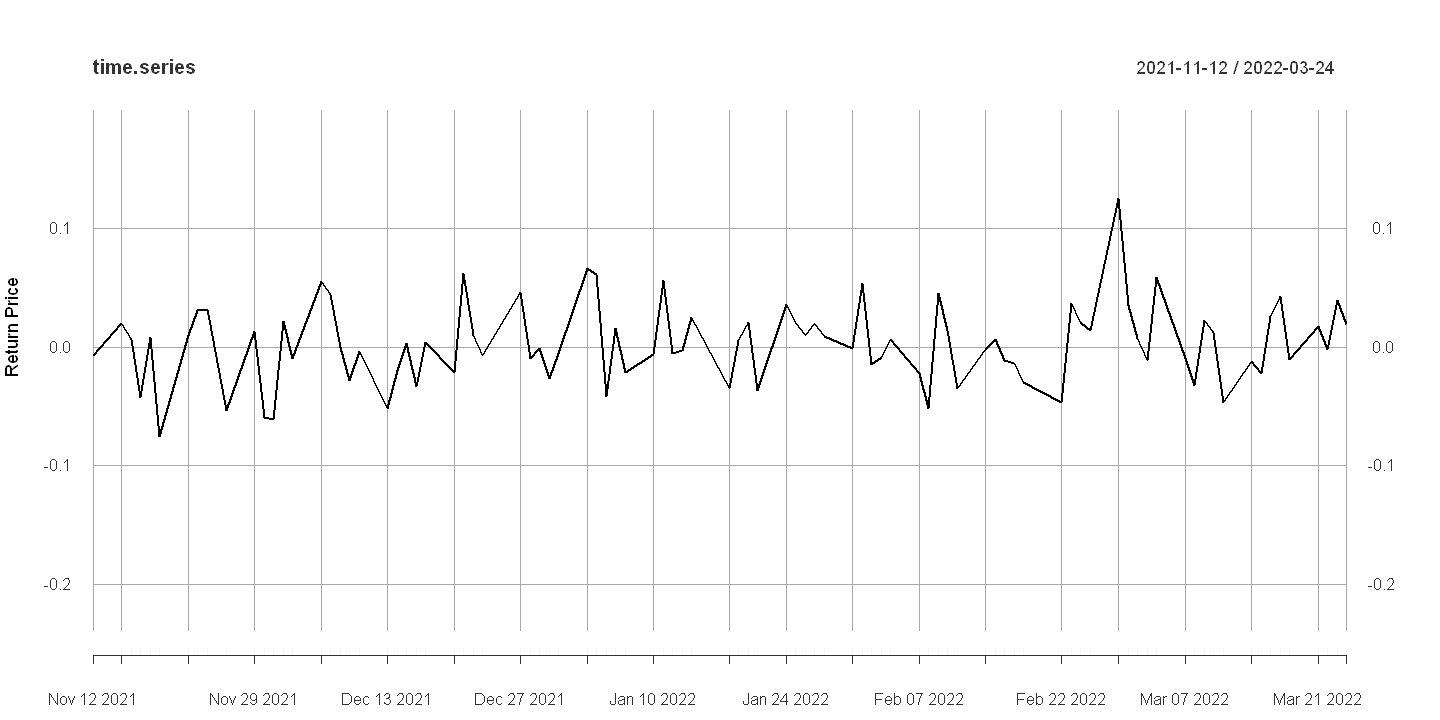

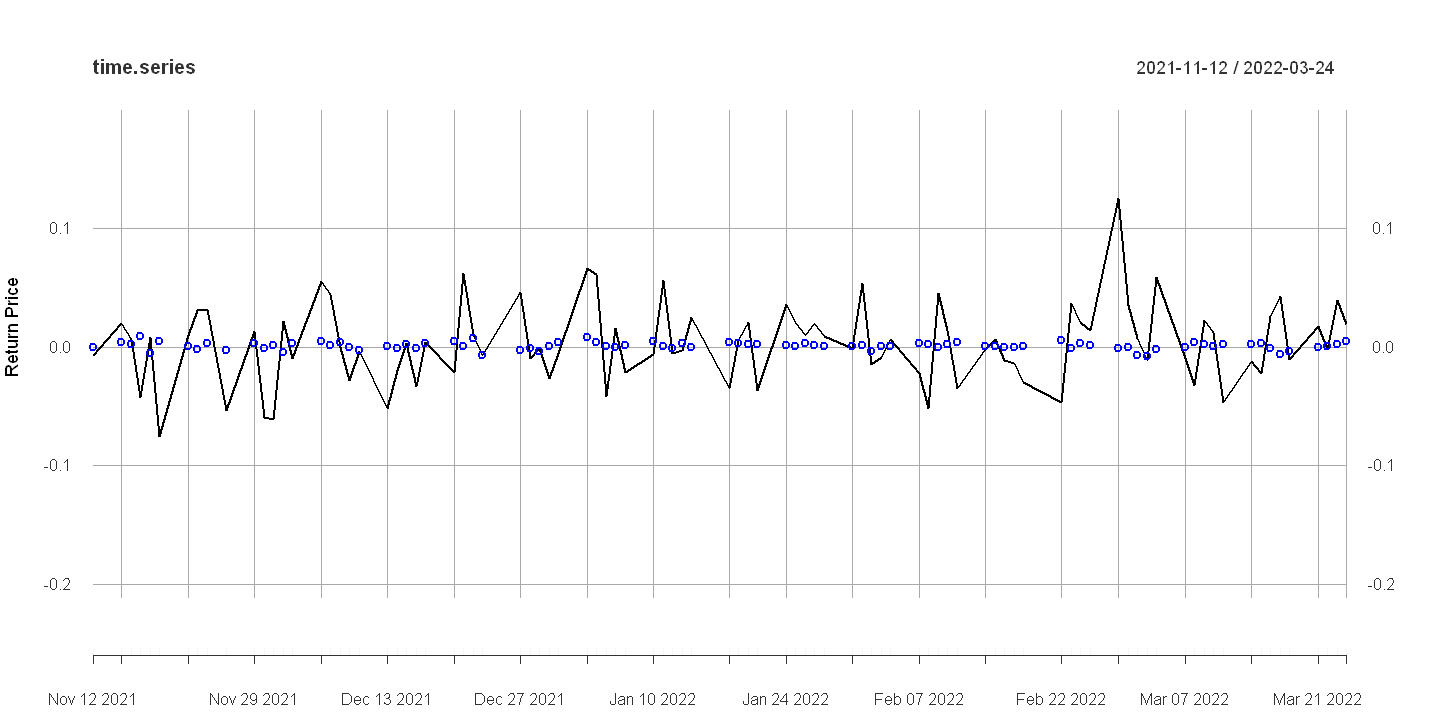

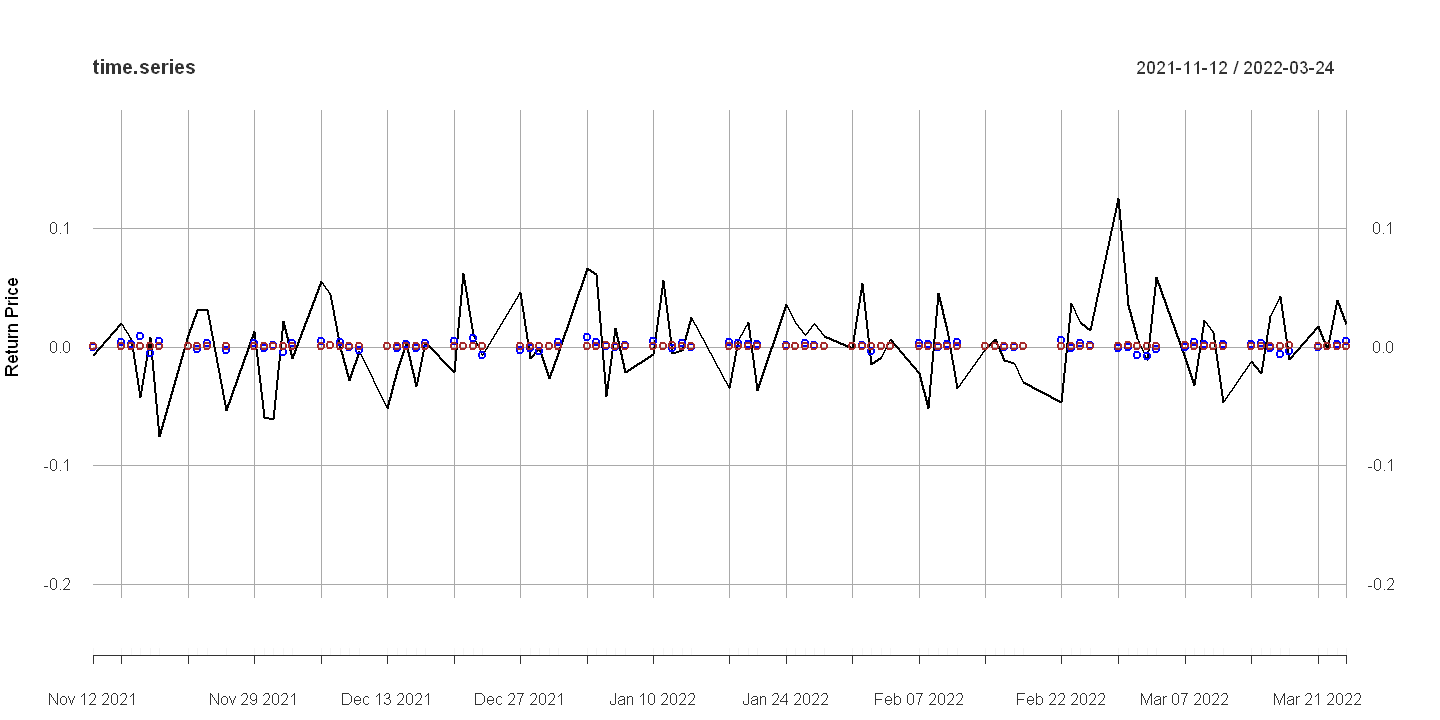

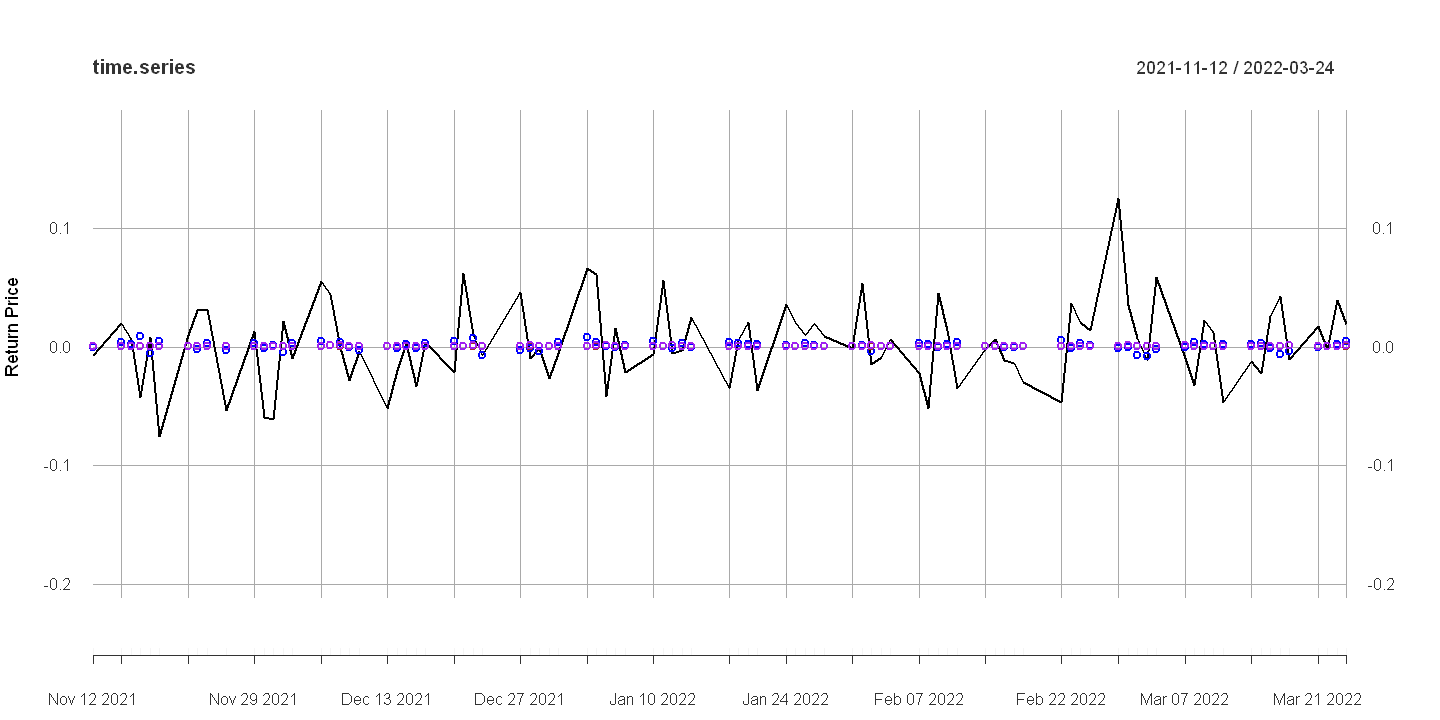

In [29]:
ymin = min(c(as.vector(pdcert.test),fore.series.1,fore.series.2,fore.series.3), na.rm = T)
ymax = max(c(as.vector(pdcert.test),fore.series.1,fore.series.2,fore.series.3), na.rm = T)
data.plot = pdcert.test
names(data.plot)="Fore"
n=length(pdcert2)
time.series = pdcert2[c(n-90):n]
plot(time.series,type="l", ylim=c(ymin,ymax), xlab="Time", ylab="Return Price")
data.plot$Fore=fore.series.1
points(data.plot,lwd= 2, col="blue")
data.plot$Fore=fore.series.2
points(data.plot,lwd= 2, col="brown")
data.plot$Fore=fore.series.3
points(data.plot,lwd= 2, col="purple")

### Variance Prediction Comparison

In this code, I'm contrasting the squared time series with the predictions for the conditional variance.

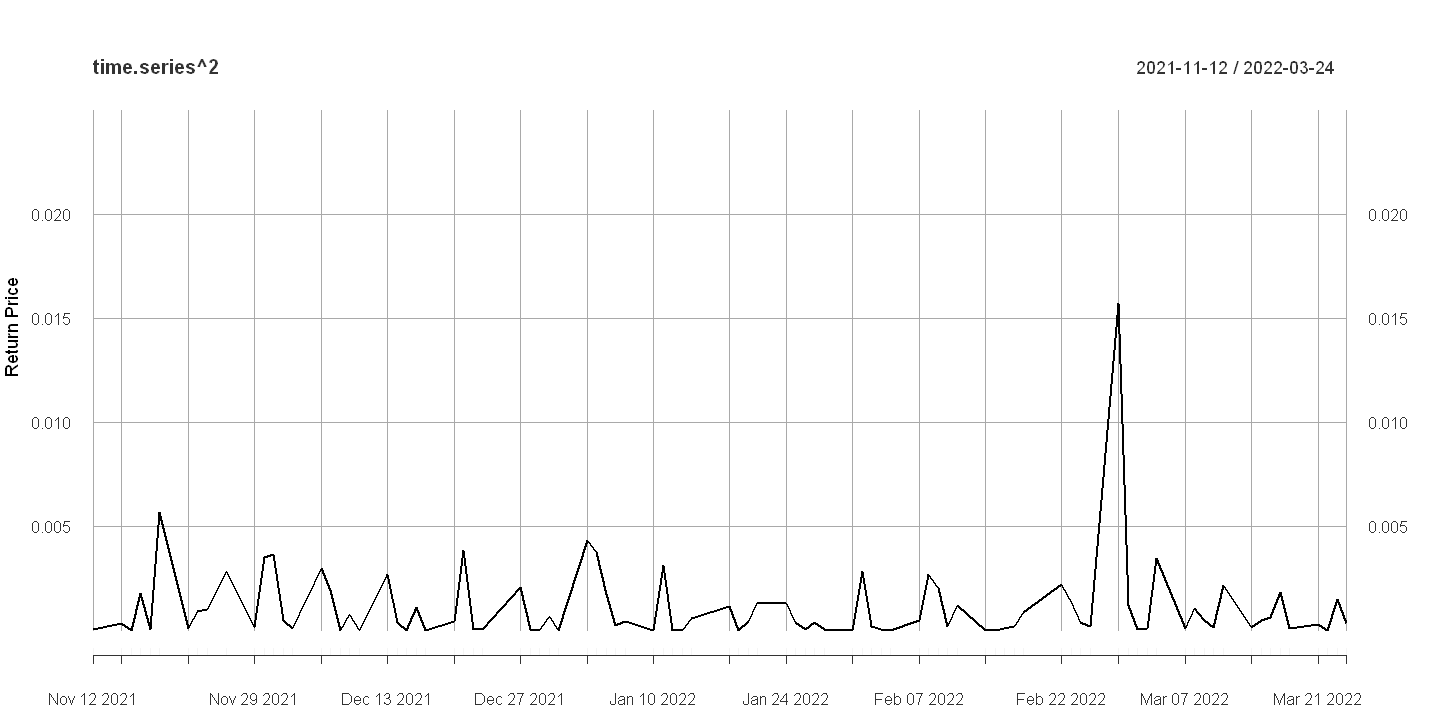

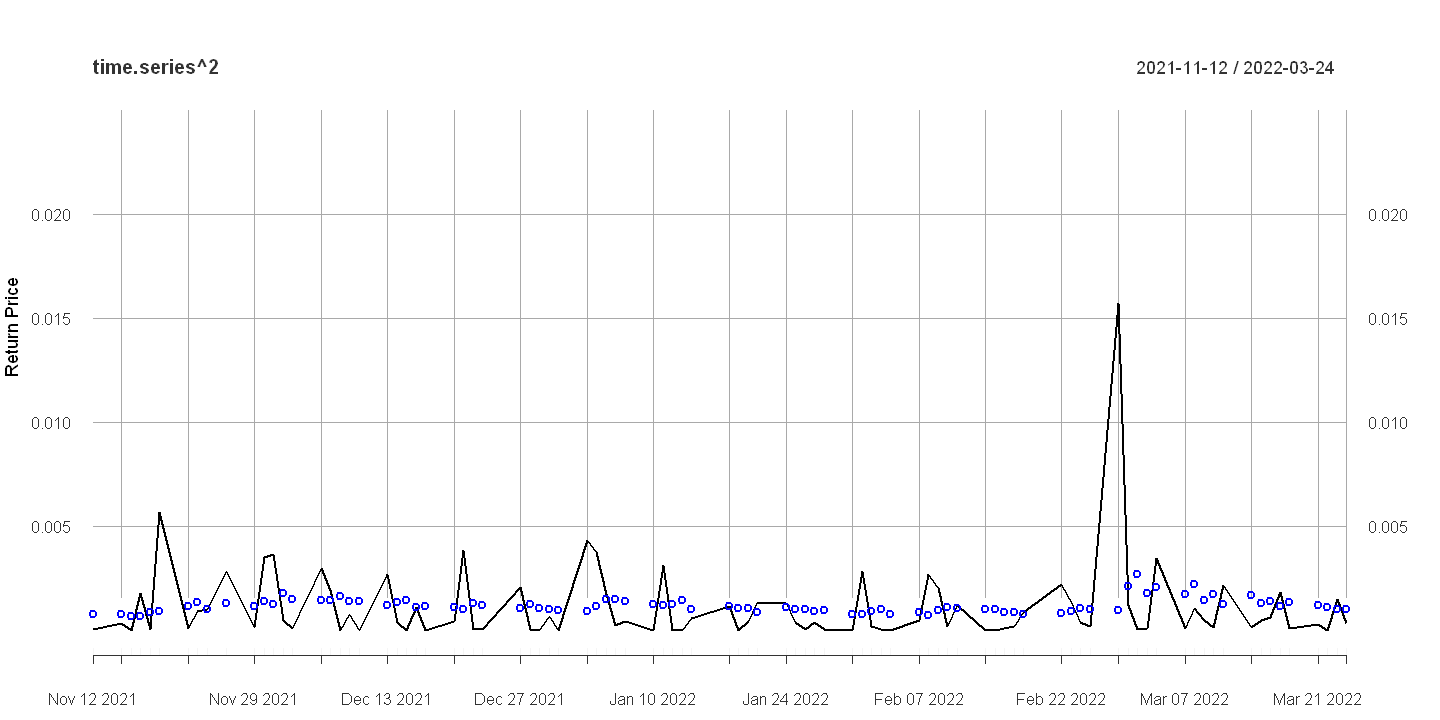

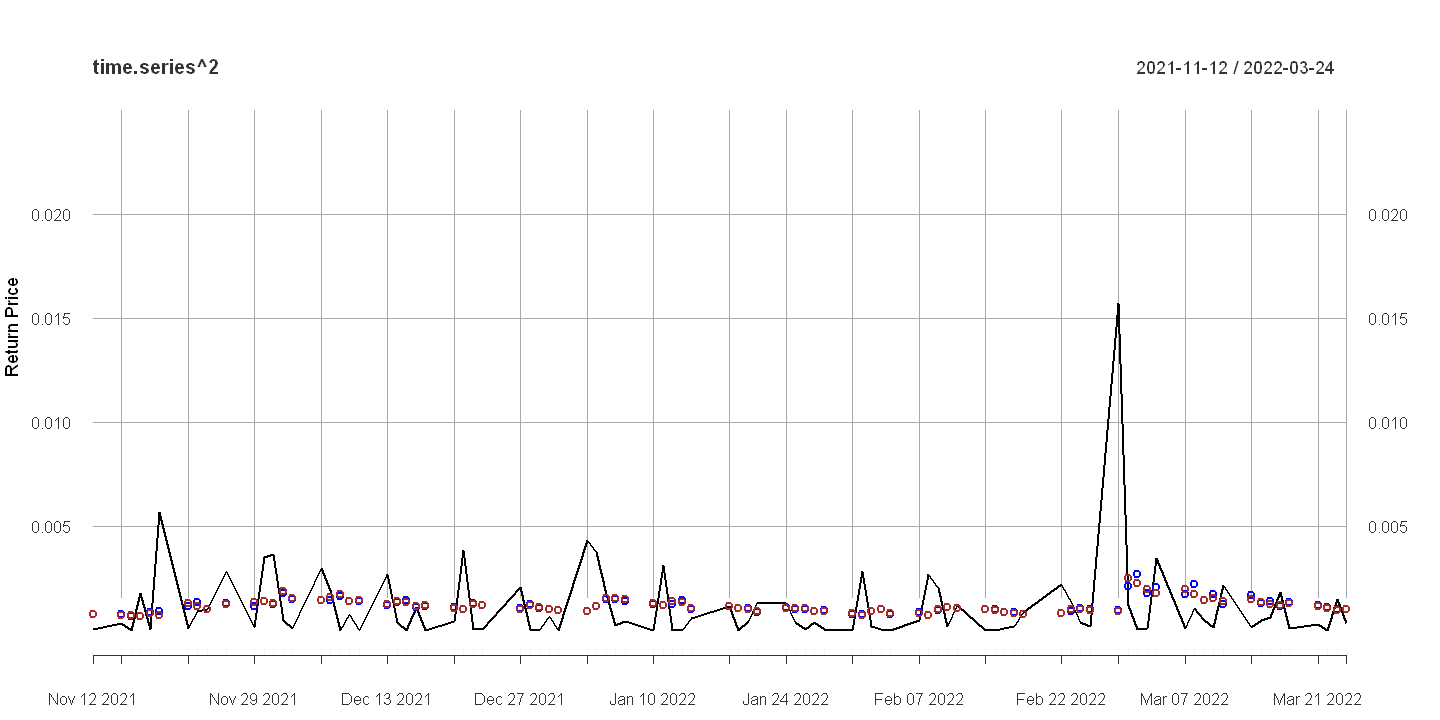

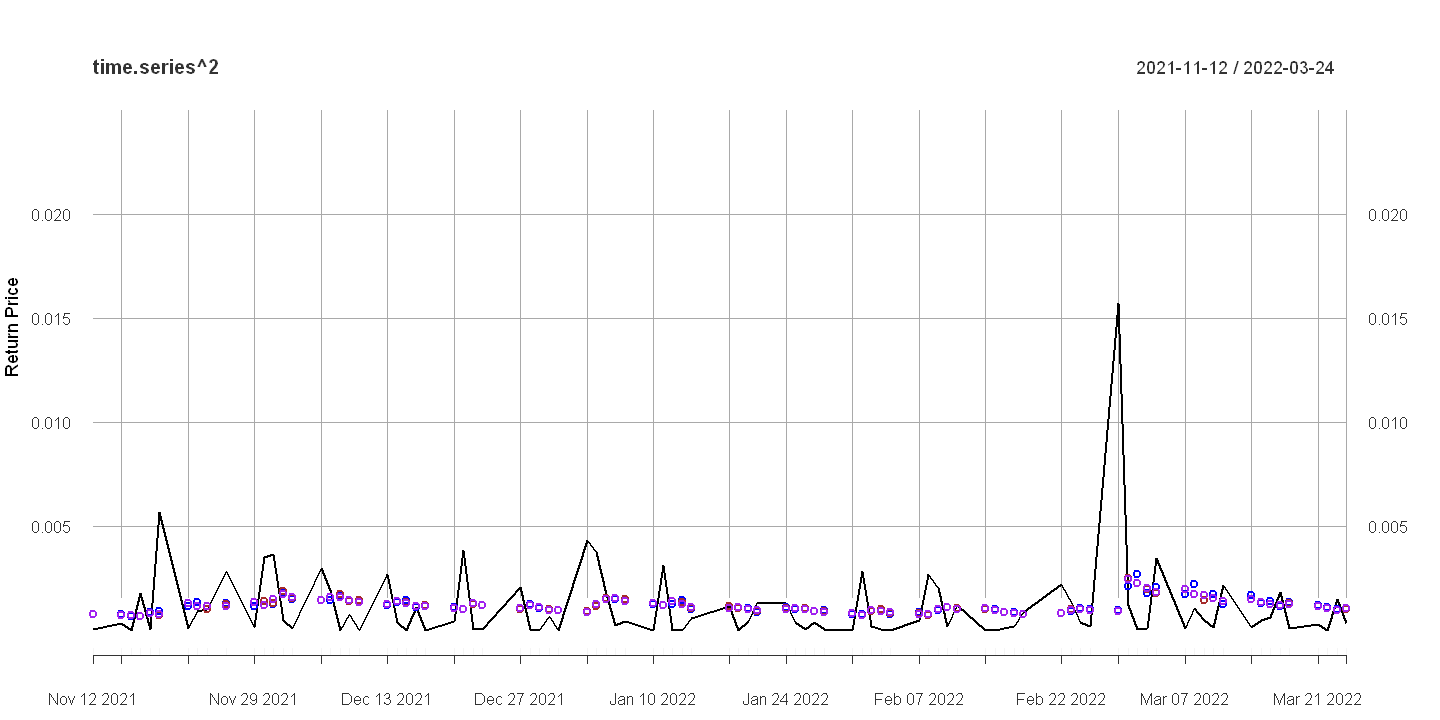

In [30]:
ymin = min(c(as.vector(pdcert.test^2),fore.sigma.1^2,fore.sigma.2^2,fore.sigma.3^2), na.rm = T)
ymax = max(c(as.vector(pdcert.test^2),fore.sigma.1^2,fore.sigma.2^2,fore.sigma.3^2), na.rm = T)


plot(time.series^2,type="l", ylim=c(ymin,0.025), xlab="Time", ylab="Return Price")
data.plot$Fore=fore.sigma.1^2
points(data.plot,lwd= 2, col="blue")
data.plot$Fore=fore.sigma.2^2
points(data.plot,lwd= 2, col="brown")
data.plot$Fore=fore.sigma.3^2
points(data.plot,lwd= 2, col="purple")

In the resulting plot, the predictions capture some of the volatility. However, all models underpredict the conditional variance or the volatility while still capturing the large volatility during the covid19 crisis.

### End